In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle

In [2]:
# reading input data 

with open('../datasets/question_titles_vec.pickle', 'rb') as f:
    X_t = pickle.load(f)
    
with open('../datasets/questions_vec.pickle', 'rb') as f:
    X_q = pickle.load(f)
    
with open('../datasets/answers_vec.pickle', 'rb') as f:
    X_a = pickle.load(f)

In [3]:
X_t.shape, X_q.shape, X_a.shape

((6076, 32, 300), (6076, 500, 300), (6076, 500, 300))

In [4]:
data = pd.read_pickle('../datasets/train_processed.pickle')

In [5]:
target_names = data.columns[3:-3].copy()

y = data[data.columns[3:-3]].values.copy()
y.shape

(6076, 30)

In [6]:
# train test split
from sklearn.model_selection import train_test_split

X_t_train, X_t_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42)
X_q_train, X_q_test, y_train, y_test = train_test_split(X_q, y, test_size=0.2, random_state=42)
X_a_train, X_a_test, y_train, y_test = train_test_split(X_a, y, test_size=0.2, random_state=42)

In [7]:
X_q_train.shape

(4860, 500, 300)

# Utility functions

In [8]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error as mse

def print_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        name = target_names[i]
        name = name + ':'
        if len(name)<40:
            name = name + ' '*(40-len(name))
        print(name, f'cor: {np.round(spearmanr(preds[:,i],reals[:,i]).correlation,3)},    mse: {np.round(mse(preds[:,i],reals[:,i]),3)}')
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    print('\n\n CORRELATION STATS: \n', pd.Series(cors).describe())
    print('\n\n MSE STATS: \n', pd.Series(mses).describe())

In [9]:
def plot_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.bar(target_names, cors)
    plt.xticks(rotation=90)
    plt.title('CORS')
    plt.subplot(1,2,2)
    plt.bar(target_names, mses)
    plt.xticks(rotation=90)
    plt.title('MSEs')

In [10]:
# scatterplots

def scatterplots(target_names, preds, reals):
    plt.figure(figsize=(25,35))
    for i in range(len(target_names)):
        plt.subplot(10,3,i+1)
        plt.scatter(preds[:,i],reals[:,i])
        plt.title(target_names[i])
        plt.tight_layout()
    plt.show()

In [11]:
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, restore_best_weights=True)

In [12]:
import tensorflow.keras.backend as K

class attention_many_to_one(keras.layers.Layer):

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        #super().build(input_shape)

    def call(self,x):
        # like time-distributed dense
        # each time point has n features
        # takes dot of features with weights (weights have dim n)
        # returns vector of len t - for each timepoint, just one value is returned
        # squeezed from (t,1) to t
        dots=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        softmax_weights=K.softmax(dots)
        softmax_weights=K.expand_dims(softmax_weights,axis=-1)
        # each time point is miltiplied by corresponding scalar
        # this gives greater weight to more important words in output sequence
        output=x*softmax_weights
        # all t time ponts are summed to get just one vector of dim n
        return K.sum(output,axis=1)

# LSTM Model

In [10]:
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(input_q)

input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(input_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [13]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 10s 297ms/step - loss: 0.1538 - val_loss: 0.1391
Epoch 2/500
34/34 [==============================] - 8s 232ms/step - loss: 0.1255 - val_loss: 0.1146
Epoch 3/500
34/34 [==============================] - 8s 236ms/step - loss: 0.1058 - val_loss: 0.0998
Epoch 4/500
34/34 [==============================] - 8s 235ms/step - loss: 0.0940 - val_loss: 0.0907
Epoch 5/500
34/34 [==============================] - 8s 234ms/step - loss: 0.0863 - val_loss: 0.0850
Epoch 6/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0810 - val_loss: 0.0807
Epoch 7/500
34/34 [==============================] - 8s 236ms/step - loss: 0.0770 - val_loss: 0.0772
Epoch 8/500
34/34 [==============================] - 8s 236ms/step - loss: 0.0738 - val_loss: 0.0746
Epoch 9/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0715 - val_loss: 0.0723
Epoch 10/500
34/34 [==============================] - 8s 237ms/step - loss: 0.0694 - val_l

In [17]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [18]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.216,    mse: 0.016
question_body_critical:                  cor: 0.291,    mse: 0.044
question_conversational:                 cor: 0.39,    mse: 0.029
question_expect_short_answer:            cor: 0.117,    mse: 0.123
question_fact_seeking:                   cor: 0.216,    mse: 0.081
question_has_commonly_accepted_answer:   cor: 0.384,    mse: 0.094
question_interestingness_others:         cor: 0.335,    mse: 0.017
question_interestingness_self:           cor: 0.425,    mse: 0.029
question_multi_intent:                   cor: 0.237,    mse: 0.106
question_not_really_a_question:          cor: -0.005,    mse: 0.004
question_opinion_seeking:                cor: 0.278,    mse: 0.125
question_type_choice:                    cor: 0.297,    mse: 0.127
question_type_compare:                   cor: 0.259,    mse: 0.029
question_type_consequence:               cor: 0.04,    mse: 0.007
question_type_definition:                cor: 0.222,    mse: 0.

In [19]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.339,    mse: 0.016
question_body_critical:                  cor: 0.346,    mse: 0.042
question_conversational:                 cor: 0.414,    mse: 0.025
question_expect_short_answer:            cor: 0.235,    mse: 0.116
question_fact_seeking:                   cor: 0.366,    mse: 0.076
question_has_commonly_accepted_answer:   cor: 0.459,    mse: 0.084
question_interestingness_others:         cor: 0.33,    mse: 0.016
question_interestingness_self:           cor: 0.453,    mse: 0.027
question_multi_intent:                   cor: 0.355,    mse: 0.099
question_not_really_a_question:          cor: 0.05,    mse: 0.004
question_opinion_seeking:                cor: 0.457,    mse: 0.109
question_type_choice:                    cor: 0.43,    mse: 0.114
question_type_compare:                   cor: 0.246,    mse: 0.021
question_type_consequence:               cor: 0.129,    mse: 0.007
question_type_definition:                cor: 0.204,    mse: 0.01

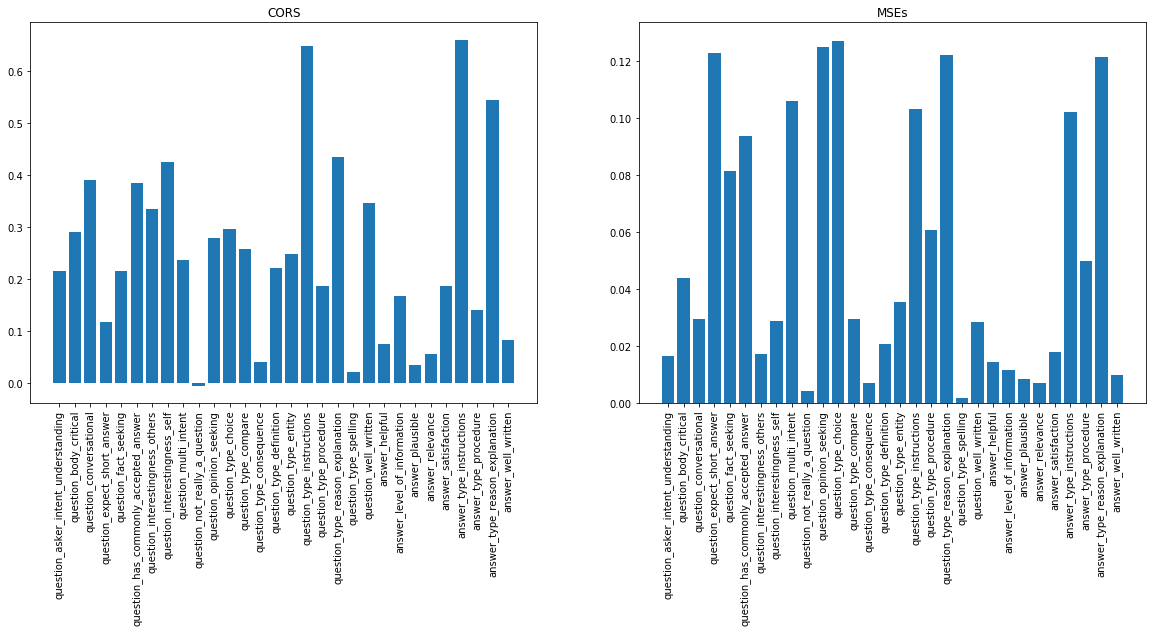

In [20]:
plot_cors_mse(target_names, preds_test, y_test)

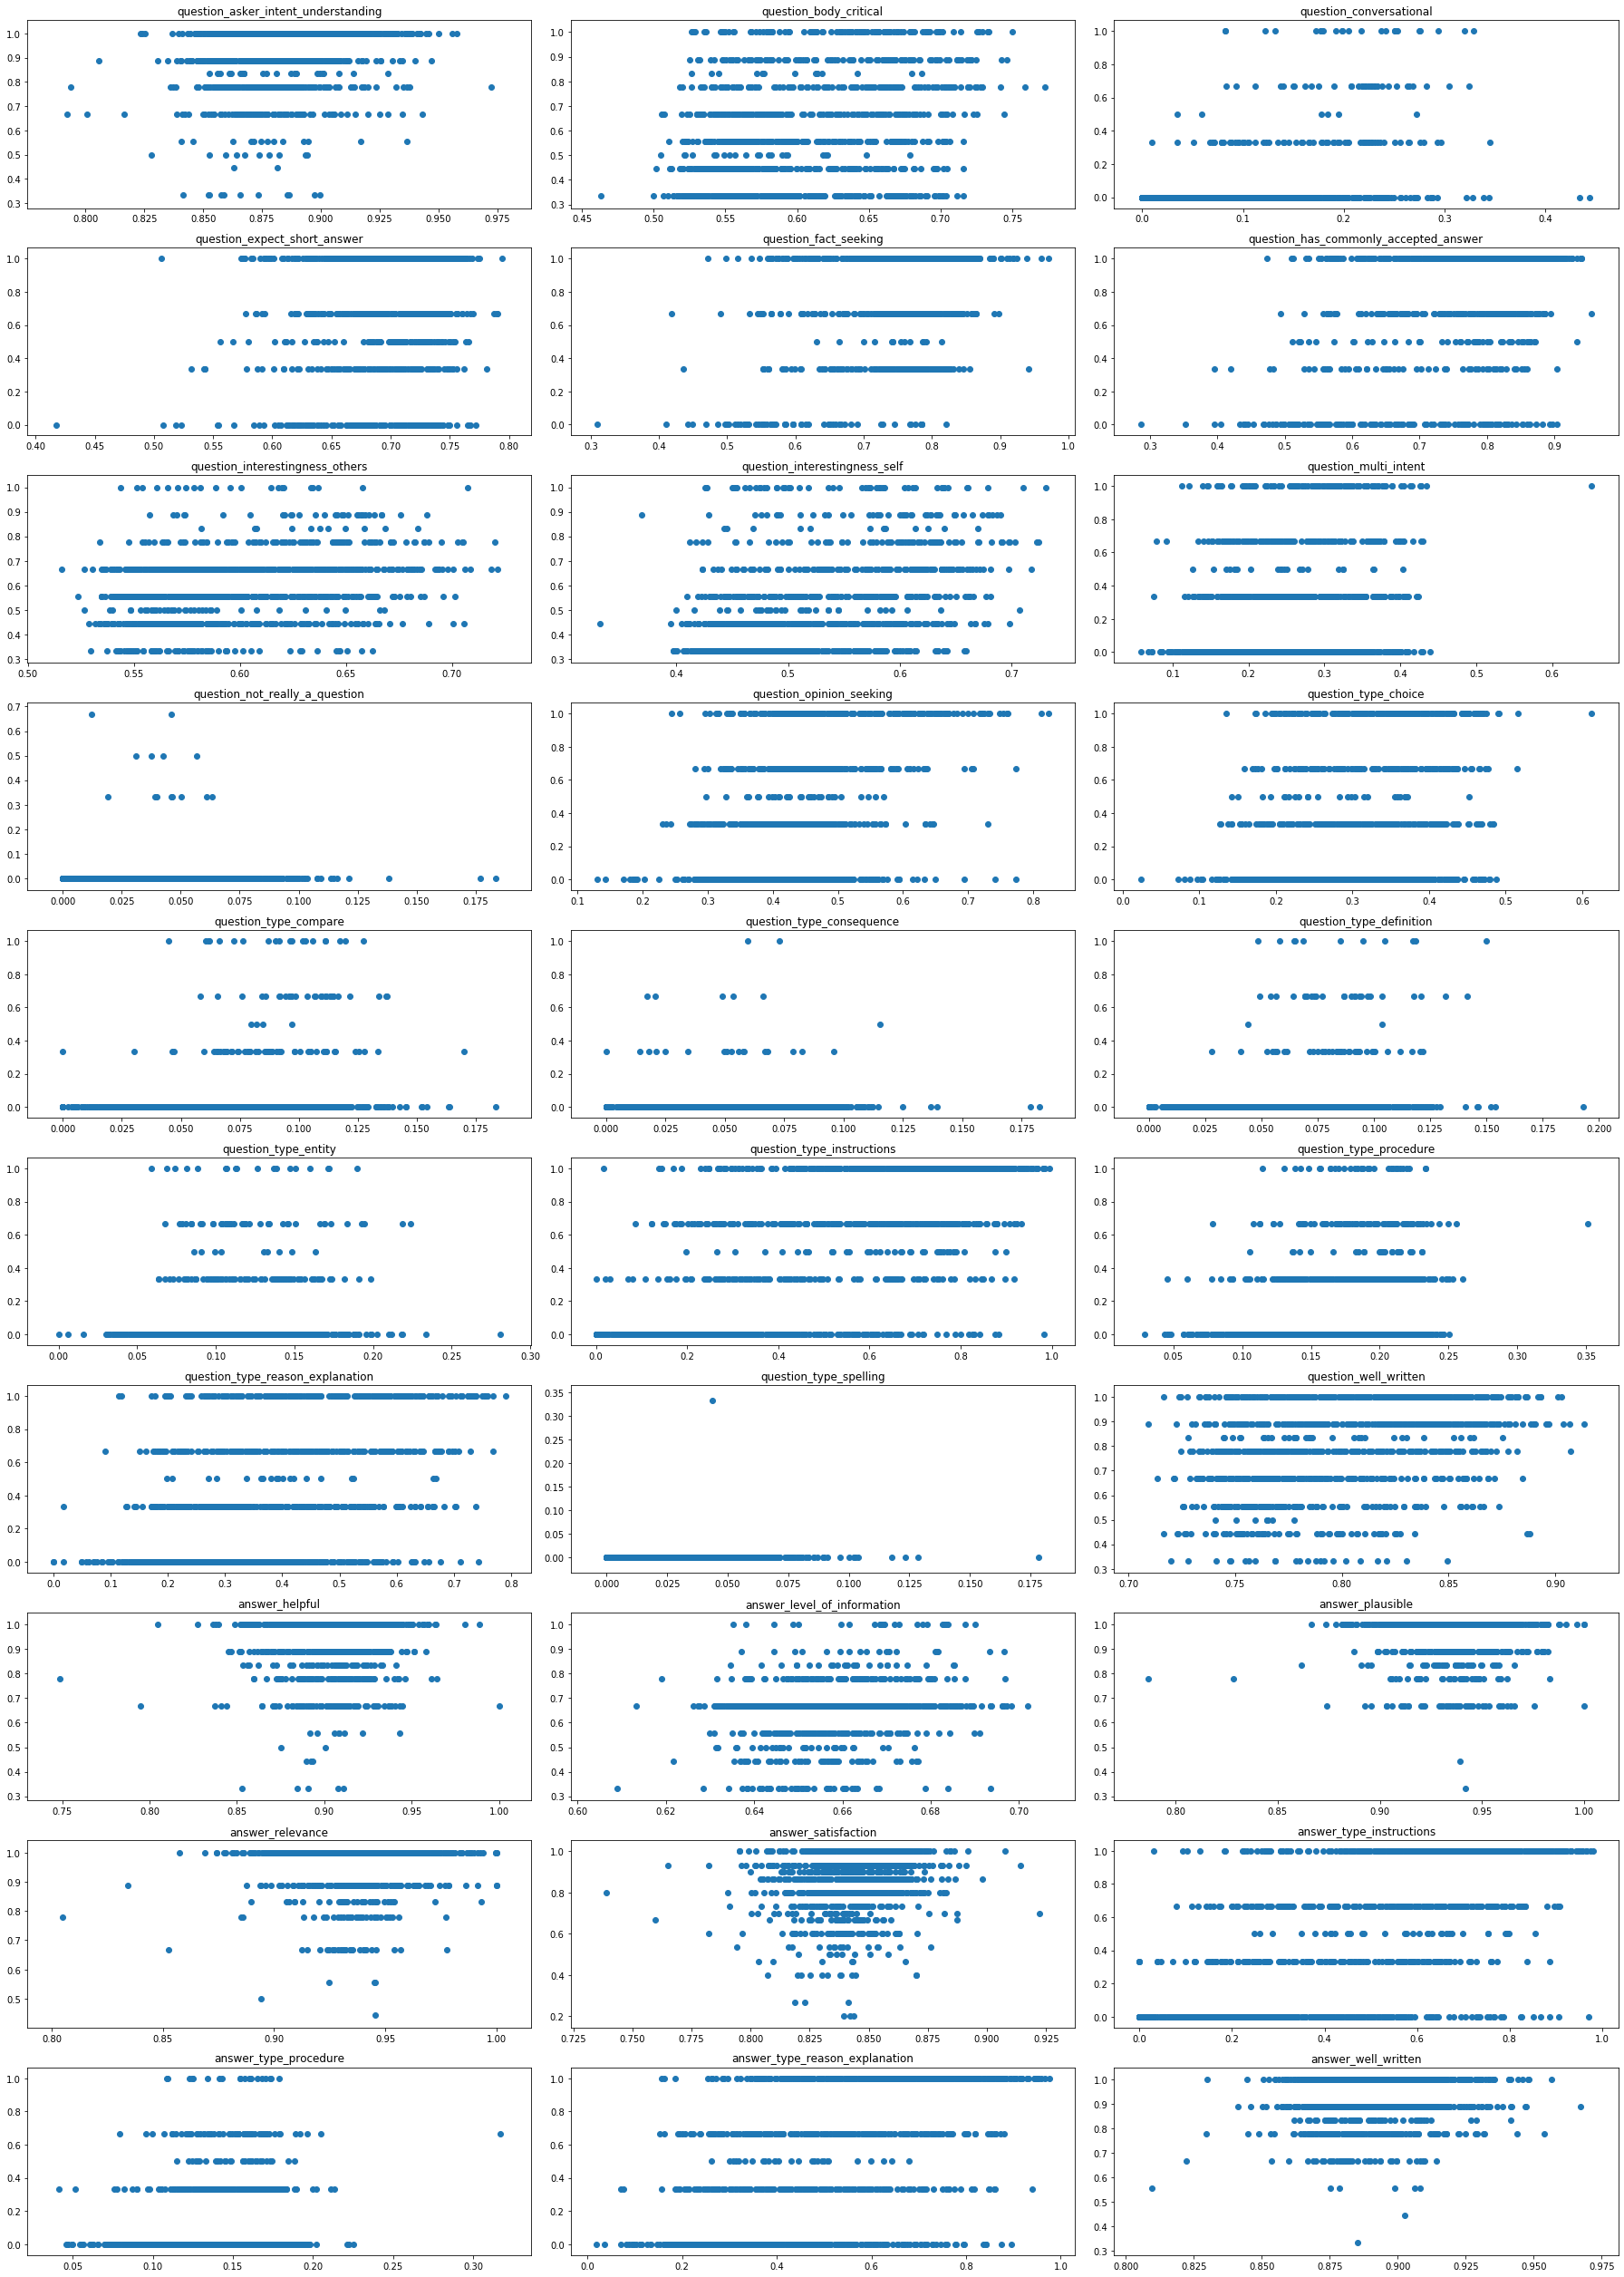

In [21]:
scatterplots(target_names, preds_test, y_test)

# Adding attention

In [22]:
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_q)

input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3))(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(64, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [23]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 13s 373ms/step - loss: 0.1567 - val_loss: 0.1422
Epoch 2/500
34/34 [==============================] - 11s 328ms/step - loss: 0.1270 - val_loss: 0.1149
Epoch 3/500
34/34 [==============================] - 11s 336ms/step - loss: 0.1054 - val_loss: 0.0989
Epoch 4/500
34/34 [==============================] - 11s 313ms/step - loss: 0.0929 - val_loss: 0.0895
Epoch 5/500
34/34 [==============================] - 11s 330ms/step - loss: 0.0850 - val_loss: 0.0833
Epoch 6/500
34/34 [==============================] - 11s 318ms/step - loss: 0.0798 - val_loss: 0.0789
Epoch 7/500
34/34 [==============================] - 11s 311ms/step - loss: 0.0758 - val_loss: 0.0757
Epoch 8/500
34/34 [==============================] - 11s 312ms/step - loss: 0.0728 - val_loss: 0.0733
Epoch 9/500
34/34 [==============================] - 11s 319ms/step - loss: 0.0706 - val_loss: 0.0714
Epoch 10/500
34/34 [==============================] - 11s 321ms/step - loss: 0.068

In [24]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [26]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.209,    mse: 0.017
question_body_critical:                  cor: 0.382,    mse: 0.041
question_conversational:                 cor: 0.407,    mse: 0.029
question_expect_short_answer:            cor: 0.199,    mse: 0.12
question_fact_seeking:                   cor: 0.22,    mse: 0.081
question_has_commonly_accepted_answer:   cor: 0.397,    mse: 0.092
question_interestingness_others:         cor: 0.335,    mse: 0.017
question_interestingness_self:           cor: 0.407,    mse: 0.029
question_multi_intent:                   cor: 0.356,    mse: 0.098
question_not_really_a_question:          cor: 0.009,    mse: 0.004
question_opinion_seeking:                cor: 0.349,    mse: 0.121
question_type_choice:                    cor: 0.267,    mse: 0.13
question_type_compare:                   cor: 0.19,    mse: 0.03
question_type_consequence:               cor: 0.021,    mse: 0.008
question_type_definition:                cor: 0.258,    mse: 0.02
q

In [27]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.314,    mse: 0.016
question_body_critical:                  cor: 0.416,    mse: 0.039
question_conversational:                 cor: 0.4,    mse: 0.027
question_expect_short_answer:            cor: 0.259,    mse: 0.115
question_fact_seeking:                   cor: 0.327,    mse: 0.079
question_has_commonly_accepted_answer:   cor: 0.44,    mse: 0.087
question_interestingness_others:         cor: 0.343,    mse: 0.016
question_interestingness_self:           cor: 0.452,    mse: 0.027
question_multi_intent:                   cor: 0.453,    mse: 0.092
question_not_really_a_question:          cor: 0.012,    mse: 0.004
question_opinion_seeking:                cor: 0.453,    mse: 0.109
question_type_choice:                    cor: 0.358,    mse: 0.121
question_type_compare:                   cor: 0.212,    mse: 0.022
question_type_consequence:               cor: 0.074,    mse: 0.008
question_type_definition:                cor: 0.264,    mse: 0.01

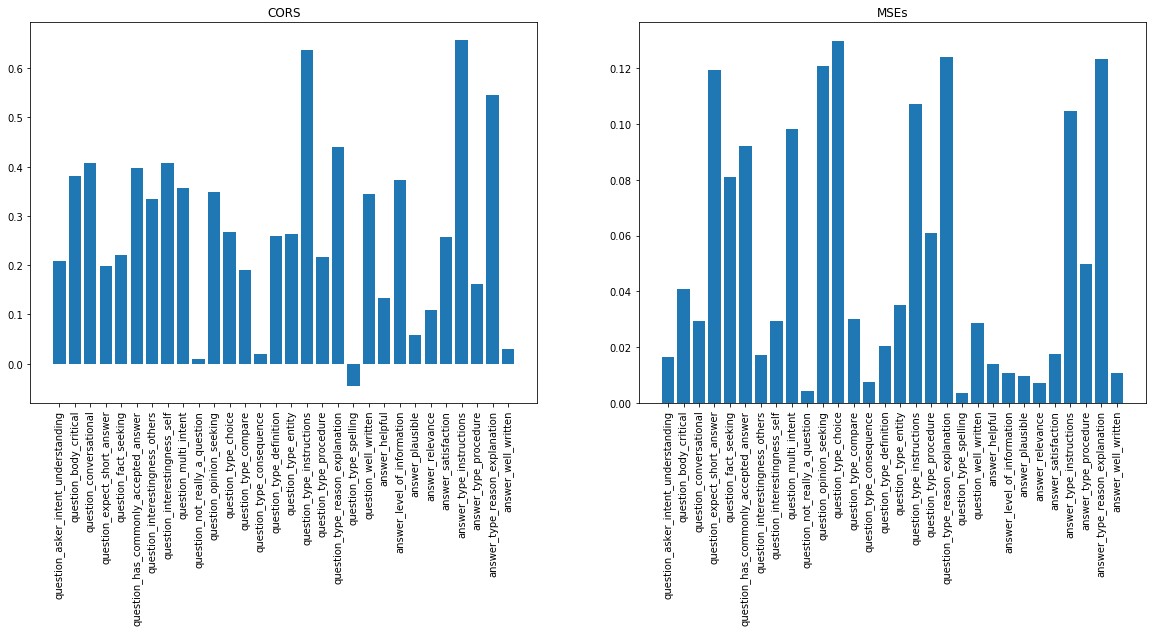

In [28]:
plot_cors_mse(target_names, preds_test, y_test)

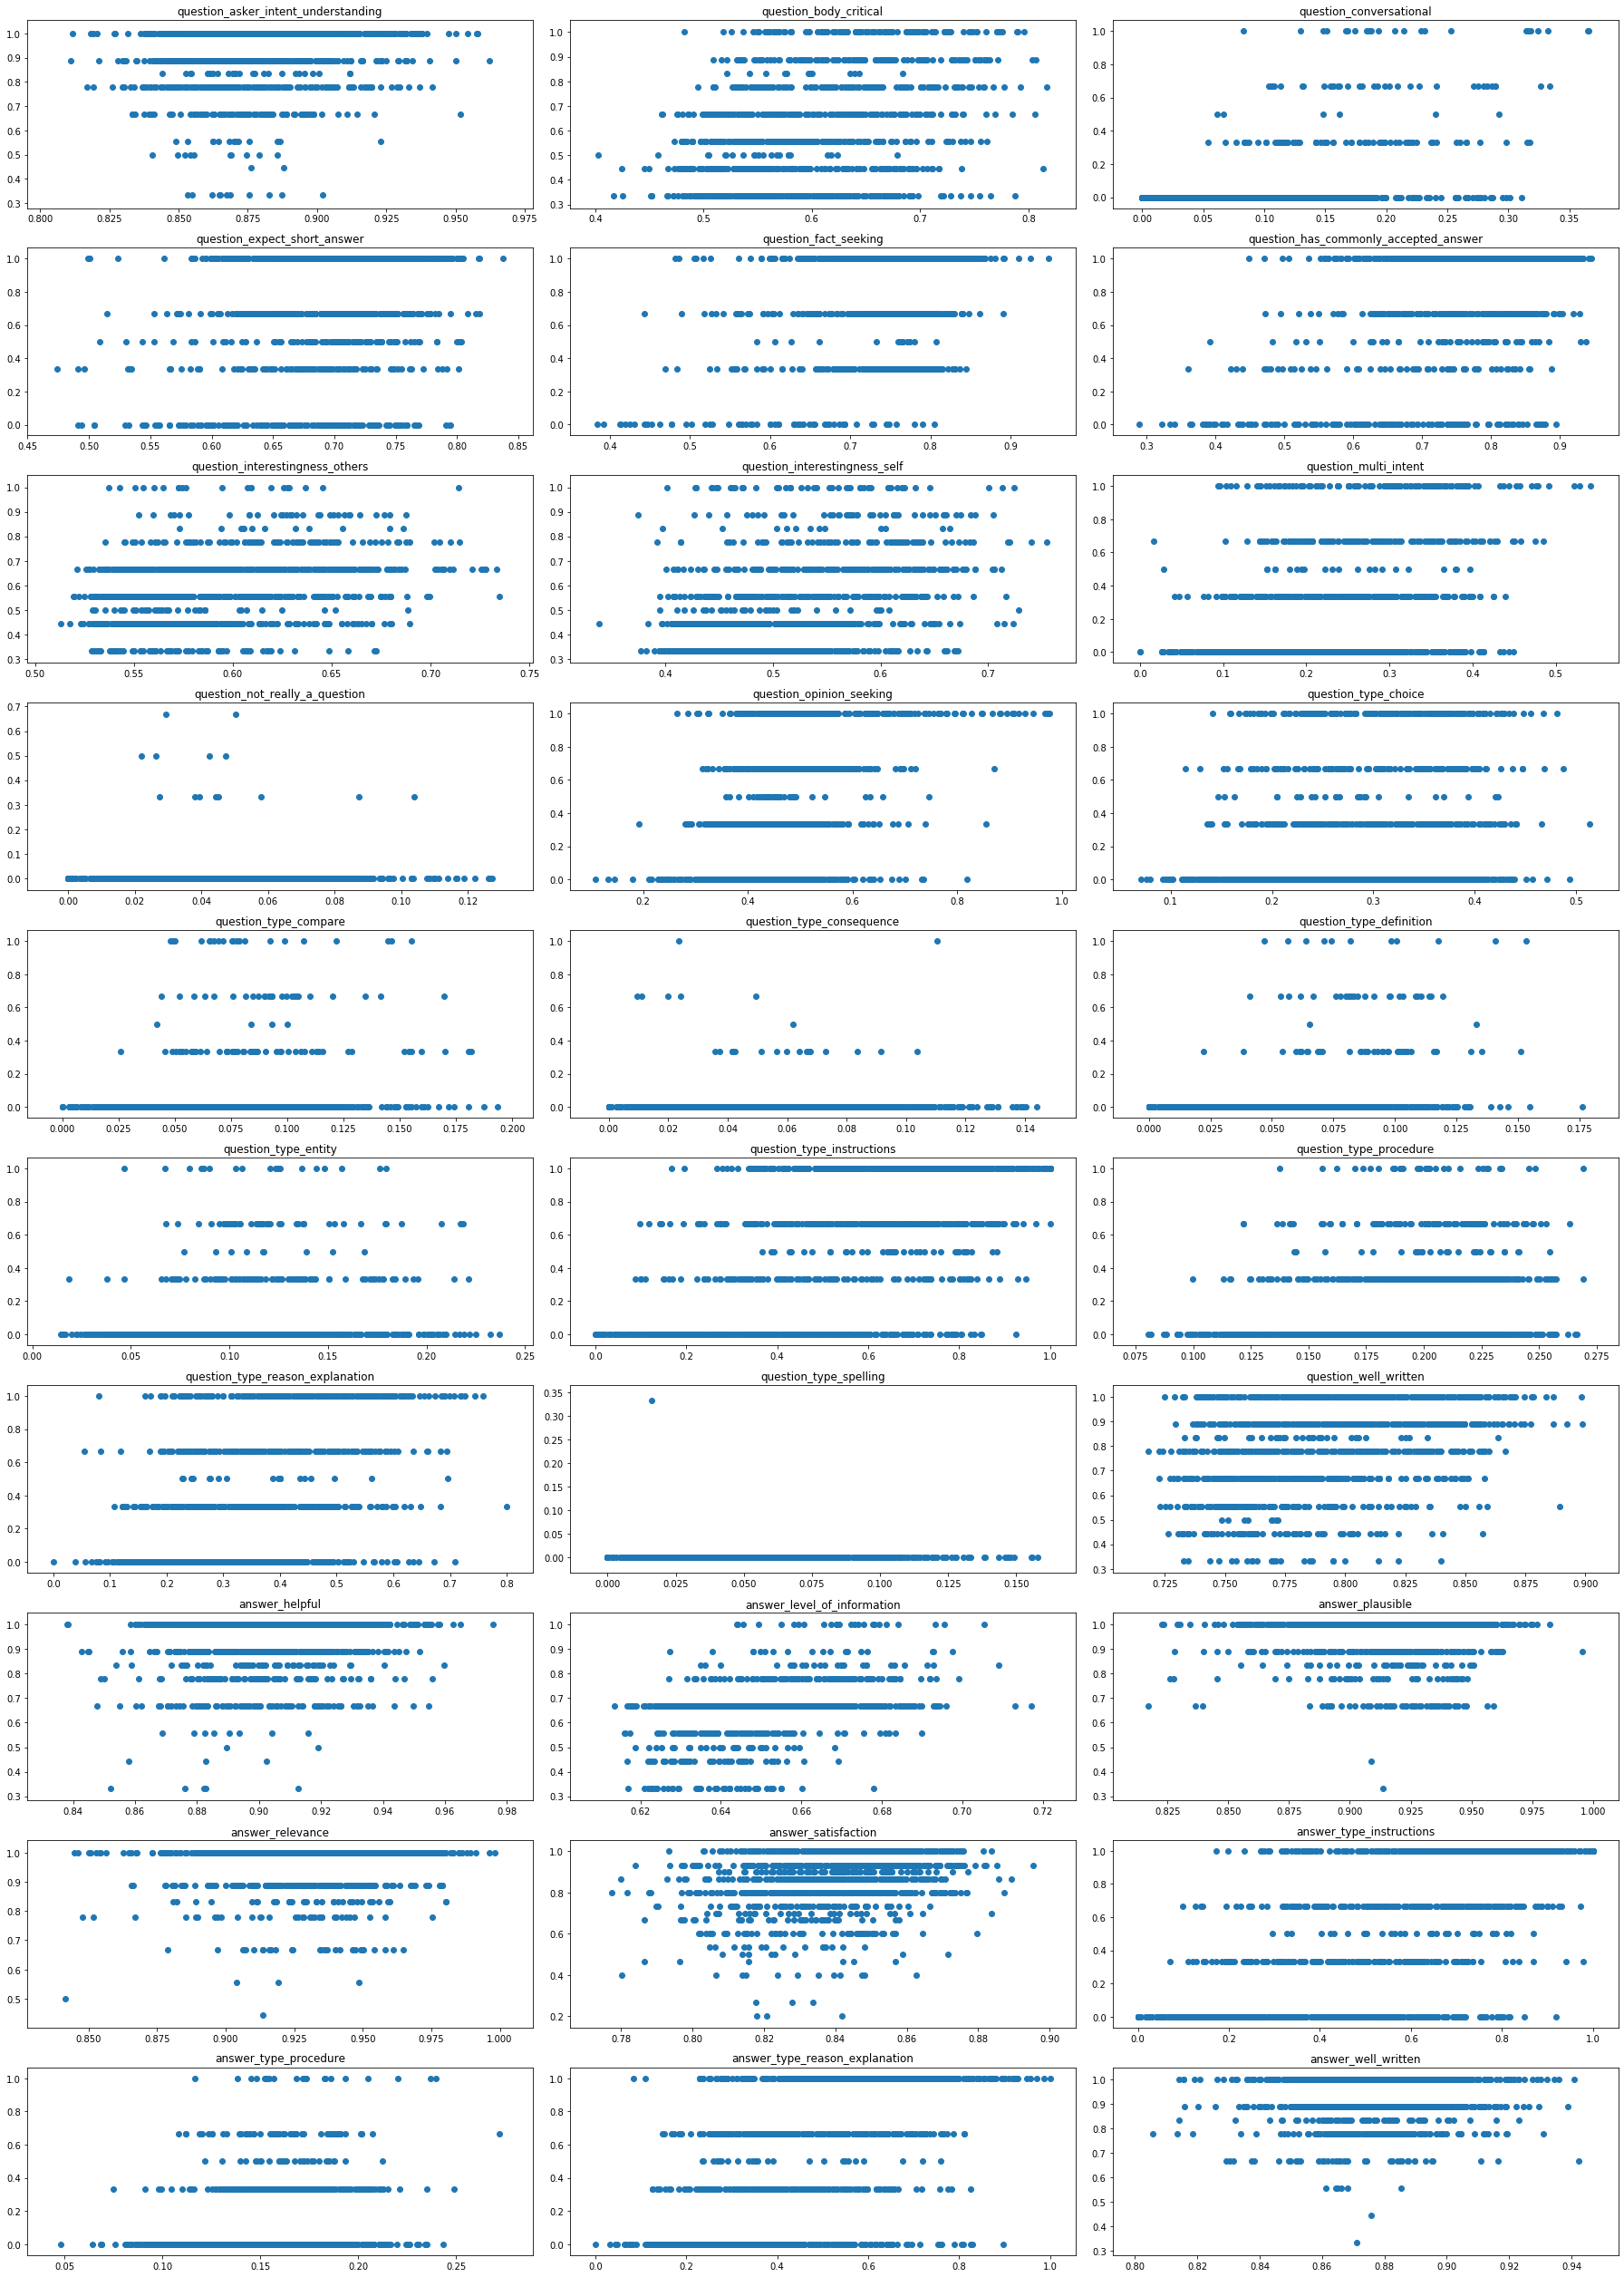

In [29]:
scatterplots(target_names, preds_test, y_test)

# Self attention, many to one attention

In [14]:
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_q)

input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True))(x_a)

x = keras.layers.concatenate((x_q, x_a))

x = keras.layers.Dense(256, activity_regularizer='l2')(x)
x = keras.layers.LeakyReLU(0.5)(x)
x = keras.layers.BatchNormalization()(x)

x = attention_many_to_one()(x)

output = keras.layers.Dense(30, activation=keras.activations.hard_sigmoid)(x)

model = keras.Model([input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [18]:
model.fit([X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 22s 653ms/step - loss: 0.3553 - val_loss: 0.1754
Epoch 2/500
34/34 [==============================] - 19s 567ms/step - loss: 0.1537 - val_loss: 0.0911
Epoch 3/500
34/34 [==============================] - 19s 561ms/step - loss: 0.0948 - val_loss: 0.0765
Epoch 4/500
34/34 [==============================] - 19s 565ms/step - loss: 0.0816 - val_loss: 0.0730
Epoch 5/500
34/34 [==============================] - 19s 566ms/step - loss: 0.0743 - val_loss: 0.0707
Epoch 6/500
34/34 [==============================] - 20s 598ms/step - loss: 0.0692 - val_loss: 0.0690
Epoch 7/500
34/34 [==============================] - 20s 592ms/step - loss: 0.0653 - val_loss: 0.0674
Epoch 8/500
34/34 [==============================] - 20s 587ms/step - loss: 0.0624 - val_loss: 0.0665
Epoch 9/500
34/34 [==============================] - 20s 593ms/step - loss: 0.0602 - val_loss: 0.0652
Epoch 10/500
34/34 [==============================] - 20s 585ms/step - loss: 0.058

In [19]:
preds_train = model.predict([X_q_train, X_a_train])
preds_test = model.predict([X_q_test, X_a_test])

In [20]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.26,    mse: 0.016
question_body_critical:                  cor: 0.391,    mse: 0.042
question_conversational:                 cor: 0.427,    mse: 0.028
question_expect_short_answer:            cor: 0.196,    mse: 0.121
question_fact_seeking:                   cor: 0.238,    mse: 0.08
question_has_commonly_accepted_answer:   cor: 0.379,    mse: 0.095
question_interestingness_others:         cor: 0.35,    mse: 0.017
question_interestingness_self:           cor: 0.43,    mse: 0.03
question_multi_intent:                   cor: 0.413,    mse: 0.097
question_not_really_a_question:          cor: 0.047,    mse: 0.002
question_opinion_seeking:                cor: 0.337,    mse: 0.122
question_type_choice:                    cor: 0.386,    mse: 0.124
question_type_compare:                   cor: 0.285,    mse: 0.03
question_type_consequence:               cor: -0.01,    mse: 0.005
question_type_definition:                cor: 0.322,    mse: 0.019
q

/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages

In [21]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.373,    mse: 0.016
question_body_critical:                  cor: 0.465,    mse: 0.04
question_conversational:                 cor: 0.424,    mse: 0.026
question_expect_short_answer:            cor: 0.337,    mse: 0.113
question_fact_seeking:                   cor: 0.355,    mse: 0.077
question_has_commonly_accepted_answer:   cor: 0.45,    mse: 0.089
question_interestingness_others:         cor: 0.38,    mse: 0.016
question_interestingness_self:           cor: 0.497,    mse: 0.028
question_multi_intent:                   cor: 0.543,    mse: 0.089
question_not_really_a_question:          cor: -0.009,    mse: 0.002
question_opinion_seeking:                cor: 0.448,    mse: 0.11
question_type_choice:                    cor: 0.475,    mse: 0.115
question_type_compare:                   cor: 0.291,    mse: 0.02
question_type_consequence:               cor: 0.135,    mse: 0.006
question_type_definition:                cor: 0.315,    mse: 0.017

/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


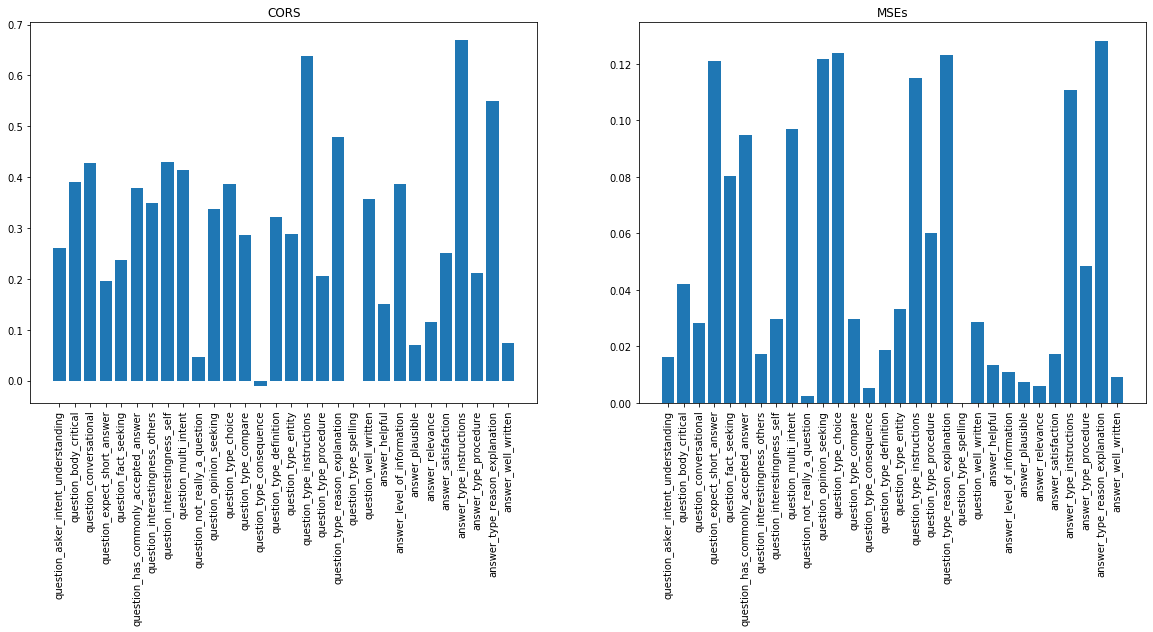

In [22]:
plot_cors_mse(target_names, preds_test, y_test)

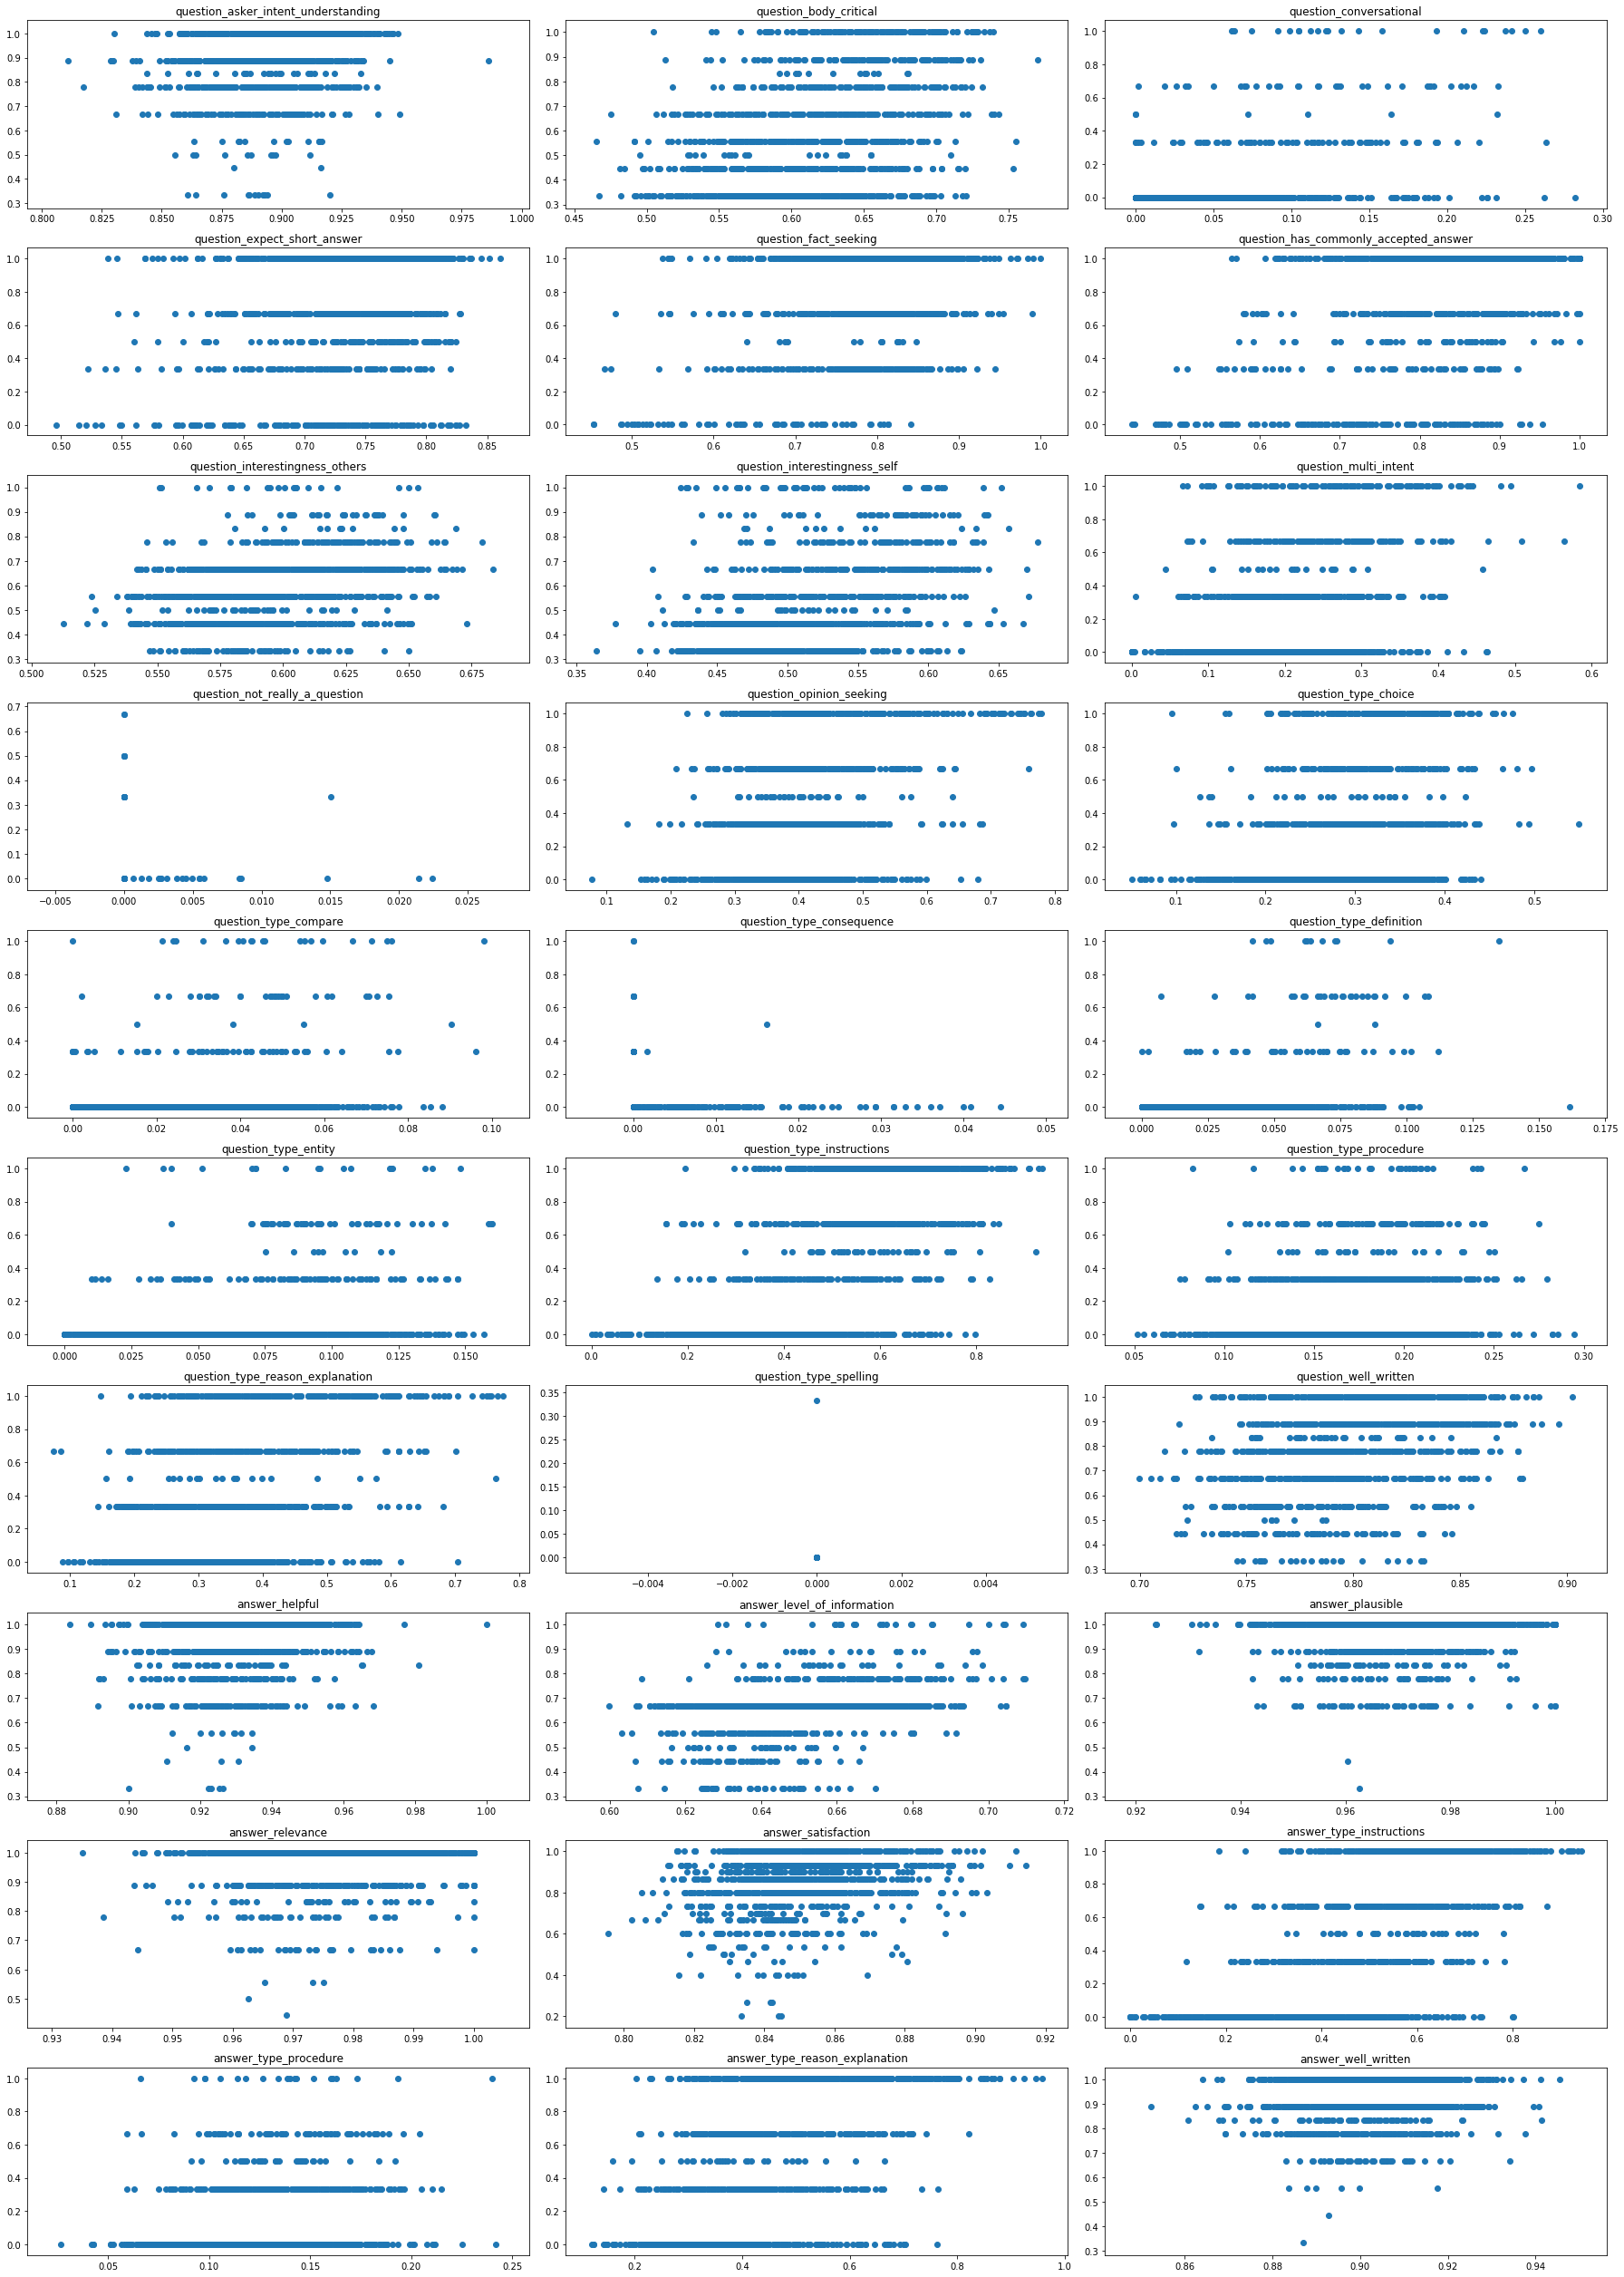

In [23]:
scatterplots(target_names, preds_test, y_test)

# Separating titles, questions and asnwers

In [13]:
input_t = keras.layers.Input(shape=(32,300))
x_t = keras.layers.Attention()([input_t,input_t])
x_t = keras.layers.Masking()(x_t)
x_t = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_t)
x_t = attention_many_to_one()(x_t)
x_t = keras.layers.BatchNormalization()(x_t)
x_t = keras.layers.Dropout(0.3)(x_t)
x_t = keras.layers.Dense(30, activity_regularizer='l2', activation=keras.activations.swish)(x_t)

input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.Masking()(x_q)
x_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_q)
x_q = attention_many_to_one()(x_q)
x_q = keras.layers.BatchNormalization()(x_q)
x_q = keras.layers.Dropout(0.3)(x_q)
x_q = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_q)


input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.Masking()(x_a)
x_a = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_a)
x_a = attention_many_to_one()(x_a)
x_a = keras.layers.BatchNormalization()(x_a)
x_a = keras.layers.Dropout(0.3)(x_a)
x_a = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_a)

x = keras.layers.concatenate((x_t, x_q, x_a))

output = keras.layers.Dense(30, activation='sigmoid')(x)

model = keras.Model([input_t, input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 300)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
attention (Attention)           (None, 32, 300)      0           input_1[0][0]                    
                                                                 input_1[0][0]         

In [15]:
model.fit([X_t_train, X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_t_test, X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 24s 708ms/step - loss: 0.5337 - val_loss: 0.2136
Epoch 2/500
34/34 [==============================] - 19s 548ms/step - loss: 0.2262 - val_loss: 0.1291
Epoch 3/500
34/34 [==============================] - 19s 565ms/step - loss: 0.1624 - val_loss: 0.1077
Epoch 4/500
34/34 [==============================] - 19s 548ms/step - loss: 0.1351 - val_loss: 0.0969
Epoch 5/500
34/34 [==============================] - 19s 550ms/step - loss: 0.1183 - val_loss: 0.0901
Epoch 6/500
34/34 [==============================] - 19s 546ms/step - loss: 0.1066 - val_loss: 0.0853
Epoch 7/500
34/34 [==============================] - 19s 548ms/step - loss: 0.0979 - val_loss: 0.0816
Epoch 8/500
34/34 [==============================] - 19s 549ms/step - loss: 0.0913 - val_loss: 0.0787
Epoch 9/500
34/34 [==============================] - 19s 546ms/step - loss: 0.0860 - val_loss: 0.0763
Epoch 10/500
34/34 [==============================] - 19s 553ms/step - loss: 0.081

In [16]:
model.save_weights('model_weights.h5')

In [14]:
model.load_weights('model_weights.h5')

In [15]:
preds_train = model.predict([X_t_train, X_q_train, X_a_train])
preds_test = model.predict([X_t_test, X_q_test, X_a_test])

In [16]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.245,    mse: 0.016
question_body_critical:                  cor: 0.56,    mse: 0.034
question_conversational:                 cor: 0.401,    mse: 0.029
question_expect_short_answer:            cor: 0.214,    mse: 0.118
question_fact_seeking:                   cor: 0.224,    mse: 0.079
question_has_commonly_accepted_answer:   cor: 0.383,    mse: 0.087
question_interestingness_others:         cor: 0.362,    mse: 0.017
question_interestingness_self:           cor: 0.419,    mse: 0.029
question_multi_intent:                   cor: 0.421,    mse: 0.092
question_not_really_a_question:          cor: 0.022,    mse: 0.005
question_opinion_seeking:                cor: 0.366,    mse: 0.117
question_type_choice:                    cor: 0.479,    mse: 0.107
question_type_compare:                   cor: 0.231,    mse: 0.03
question_type_consequence:               cor: 0.028,    mse: 0.007
question_type_definition:                cor: 0.177,    mse: 0.0

In [17]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.317,    mse: 0.017
question_body_critical:                  cor: 0.673,    mse: 0.028
question_conversational:                 cor: 0.398,    mse: 0.027
question_expect_short_answer:            cor: 0.305,    mse: 0.111
question_fact_seeking:                   cor: 0.364,    mse: 0.072
question_has_commonly_accepted_answer:   cor: 0.442,    mse: 0.081
question_interestingness_others:         cor: 0.36,    mse: 0.016
question_interestingness_self:           cor: 0.481,    mse: 0.027
question_multi_intent:                   cor: 0.536,    mse: 0.082
question_not_really_a_question:          cor: 0.019,    mse: 0.004
question_opinion_seeking:                cor: 0.479,    mse: 0.102
question_type_choice:                    cor: 0.559,    mse: 0.094
question_type_compare:                   cor: 0.213,    mse: 0.022
question_type_consequence:               cor: 0.074,    mse: 0.008
question_type_definition:                cor: 0.206,    mse: 0.

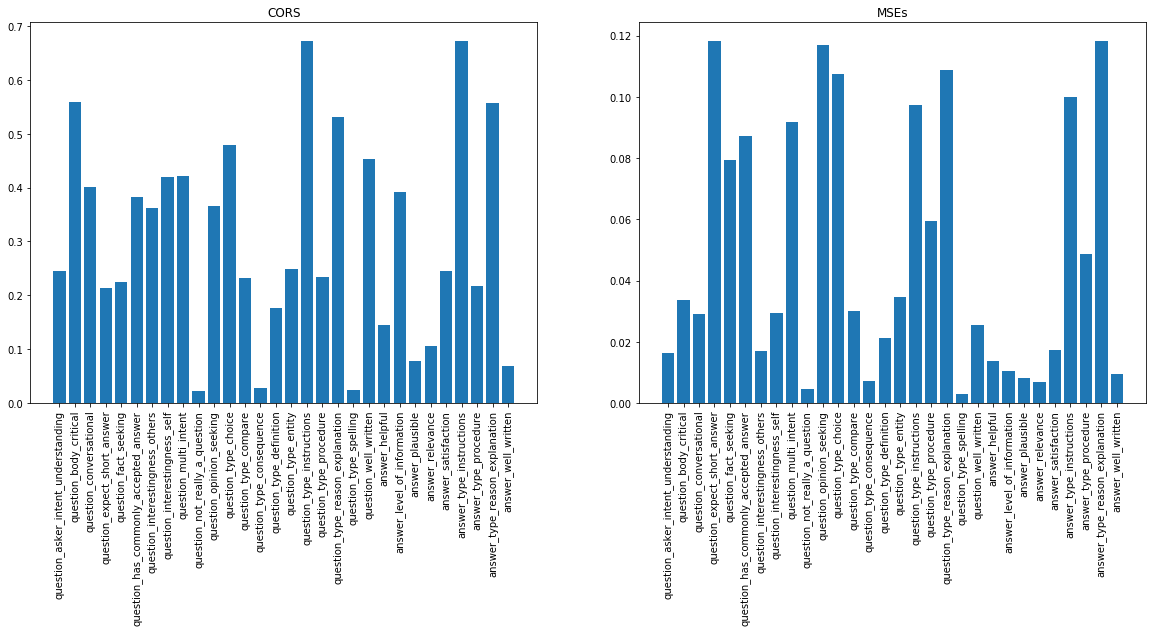

In [18]:
plot_cors_mse(target_names, preds_test, y_test)

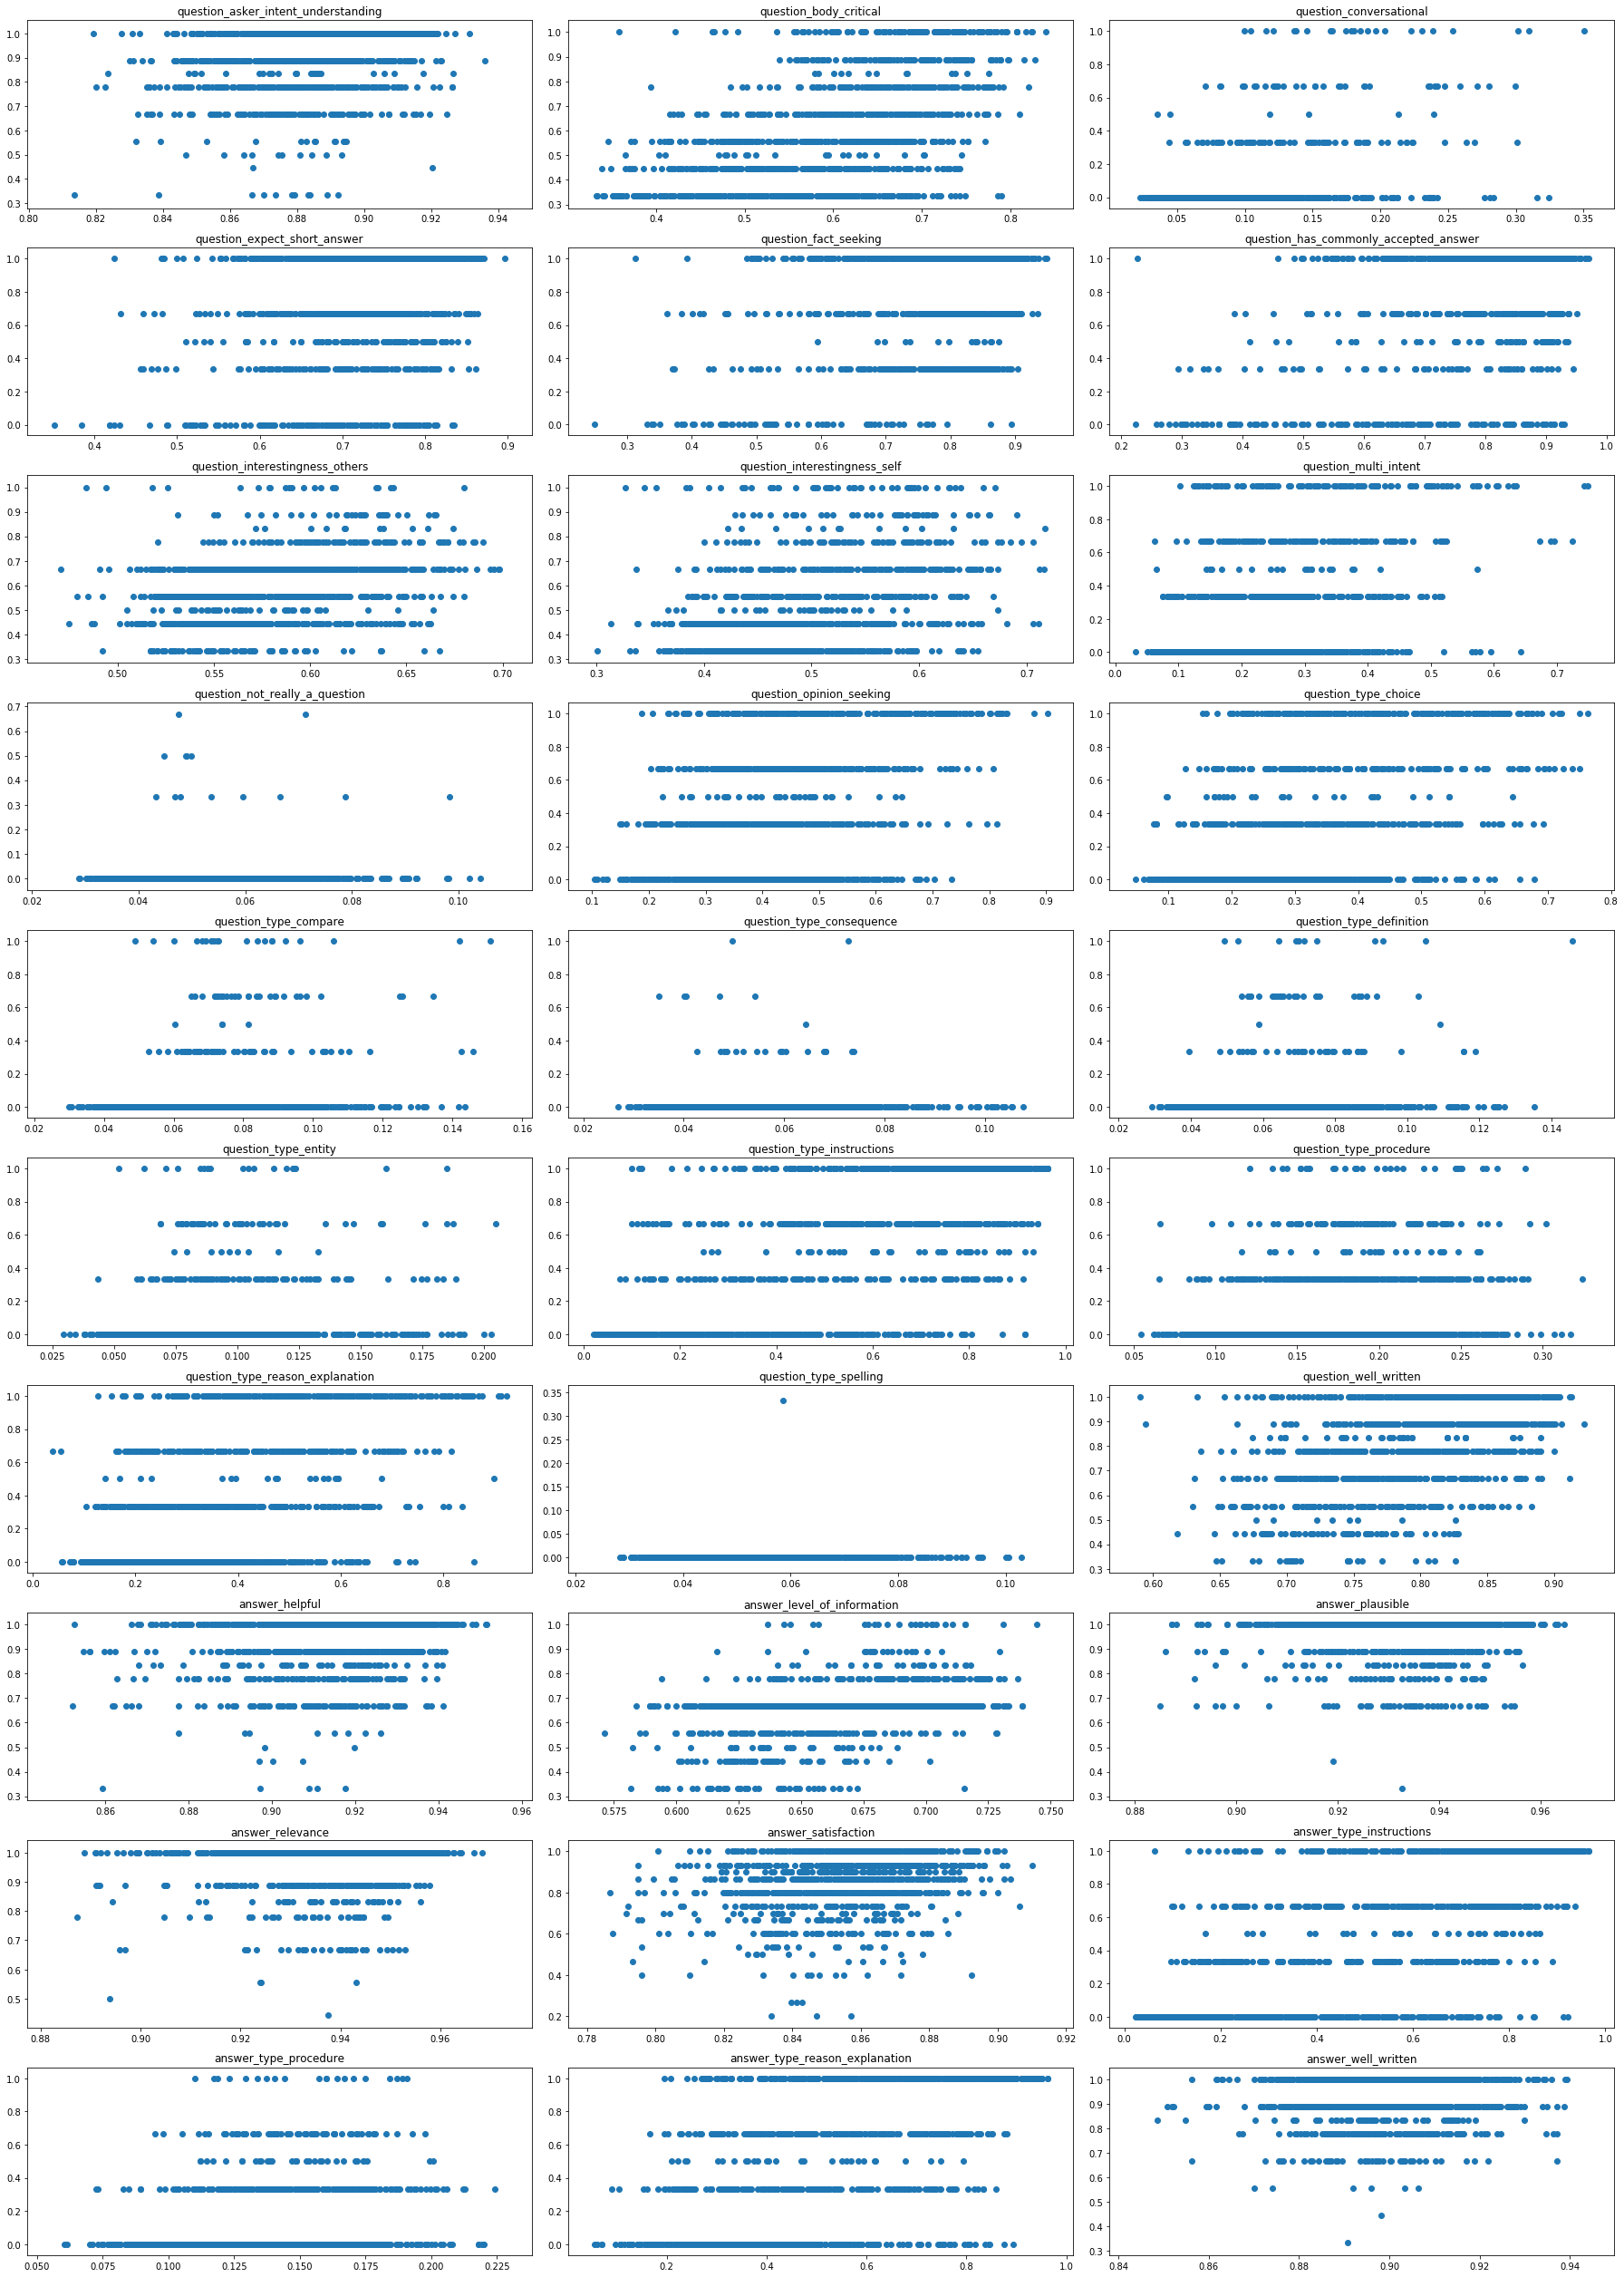

In [19]:
scatterplots(target_names, preds_test, y_test)

### Tree based regressors

Since many target variables aren't continouosly distributed, but have only few values, it makes sense to use tree based regressors. We take last layer before final in NN and use it as input set of features for tree based regressor.

In [20]:
model2 = keras.models.Model(model.input, model.get_layer('concatenate').output)

In [21]:
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 300)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
attention (Attention)           (None, 32, 300)      0           input_1[0][0]                    
                                                                 input_1[0][0]         

In [22]:
X_train_rf = model2.predict([X_t_train, X_q_train, X_a_train])
X_test_rf = model2.predict([X_t_test, X_q_test, X_a_test])

In [23]:
X_train_rf.shape, X_test_rf.shape

((4860, 230), (1216, 230))

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
rf = RandomForestRegressor(max_depth=5, n_jobs=-1)

In [24]:
from lightgbm import LGBMRegressor

reg = LGBMRegressor(learning_rate=0.005, n_estimators=500, reg_alpha=0.5, n_jobs=-1, max_depth=4)

In [25]:
preds_rf_train = []
preds_rf_test = []

for i in range(len(target_names)):
    
    y = y_train[:,i]
    
    reg.fit(X_train_rf, y)

    preds_rf_train.append(reg.predict(X_train_rf))
    preds_rf_test.append(reg.predict(X_test_rf))
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [26]:
preds_rf_train = np.array(preds_rf_train)
preds_rf_train = preds_rf_train.T

preds_rf_test = np.array(preds_rf_test)
preds_rf_test = preds_rf_test.T

In [27]:
print_cors_mse(target_names, preds_rf_test, y_test)

question_asker_intent_understanding:     cor: 0.296,    mse: 0.016
question_body_critical:                  cor: 0.578,    mse: 0.032
question_conversational:                 cor: 0.399,    mse: 0.025
question_expect_short_answer:            cor: 0.225,    mse: 0.117
question_fact_seeking:                   cor: 0.284,    mse: 0.075
question_has_commonly_accepted_answer:   cor: 0.374,    mse: 0.084
question_interestingness_others:         cor: 0.356,    mse: 0.017
question_interestingness_self:           cor: 0.443,    mse: 0.028
question_multi_intent:                   cor: 0.466,    mse: 0.086
question_not_really_a_question:          cor: 0.031,    mse: 0.002
question_opinion_seeking:                cor: 0.384,    mse: 0.114
question_type_choice:                    cor: 0.52,    mse: 0.097
question_type_compare:                   cor: 0.259,    mse: 0.027
question_type_consequence:               cor: 0.117,    mse: 0.005
question_type_definition:                cor: 0.322,    mse: 0.

In [28]:
print_cors_mse(target_names, preds_rf_train, y_train)

question_asker_intent_understanding:     cor: 0.543,    mse: 0.014
question_body_critical:                  cor: 0.743,    mse: 0.022
question_conversational:                 cor: 0.446,    mse: 0.017
question_expect_short_answer:            cor: 0.518,    mse: 0.093
question_fact_seeking:                   cor: 0.532,    mse: 0.059
question_has_commonly_accepted_answer:   cor: 0.537,    mse: 0.064
question_interestingness_others:         cor: 0.522,    mse: 0.014
question_interestingness_self:           cor: 0.604,    mse: 0.022
question_multi_intent:                   cor: 0.641,    mse: 0.061
question_not_really_a_question:          cor: 0.171,    mse: 0.002
question_opinion_seeking:                cor: 0.609,    mse: 0.086
question_type_choice:                    cor: 0.673,    mse: 0.069
question_type_compare:                   cor: 0.342,    mse: 0.014
question_type_consequence:               cor: 0.234,    mse: 0.004
question_type_definition:                cor: 0.361,    mse: 0

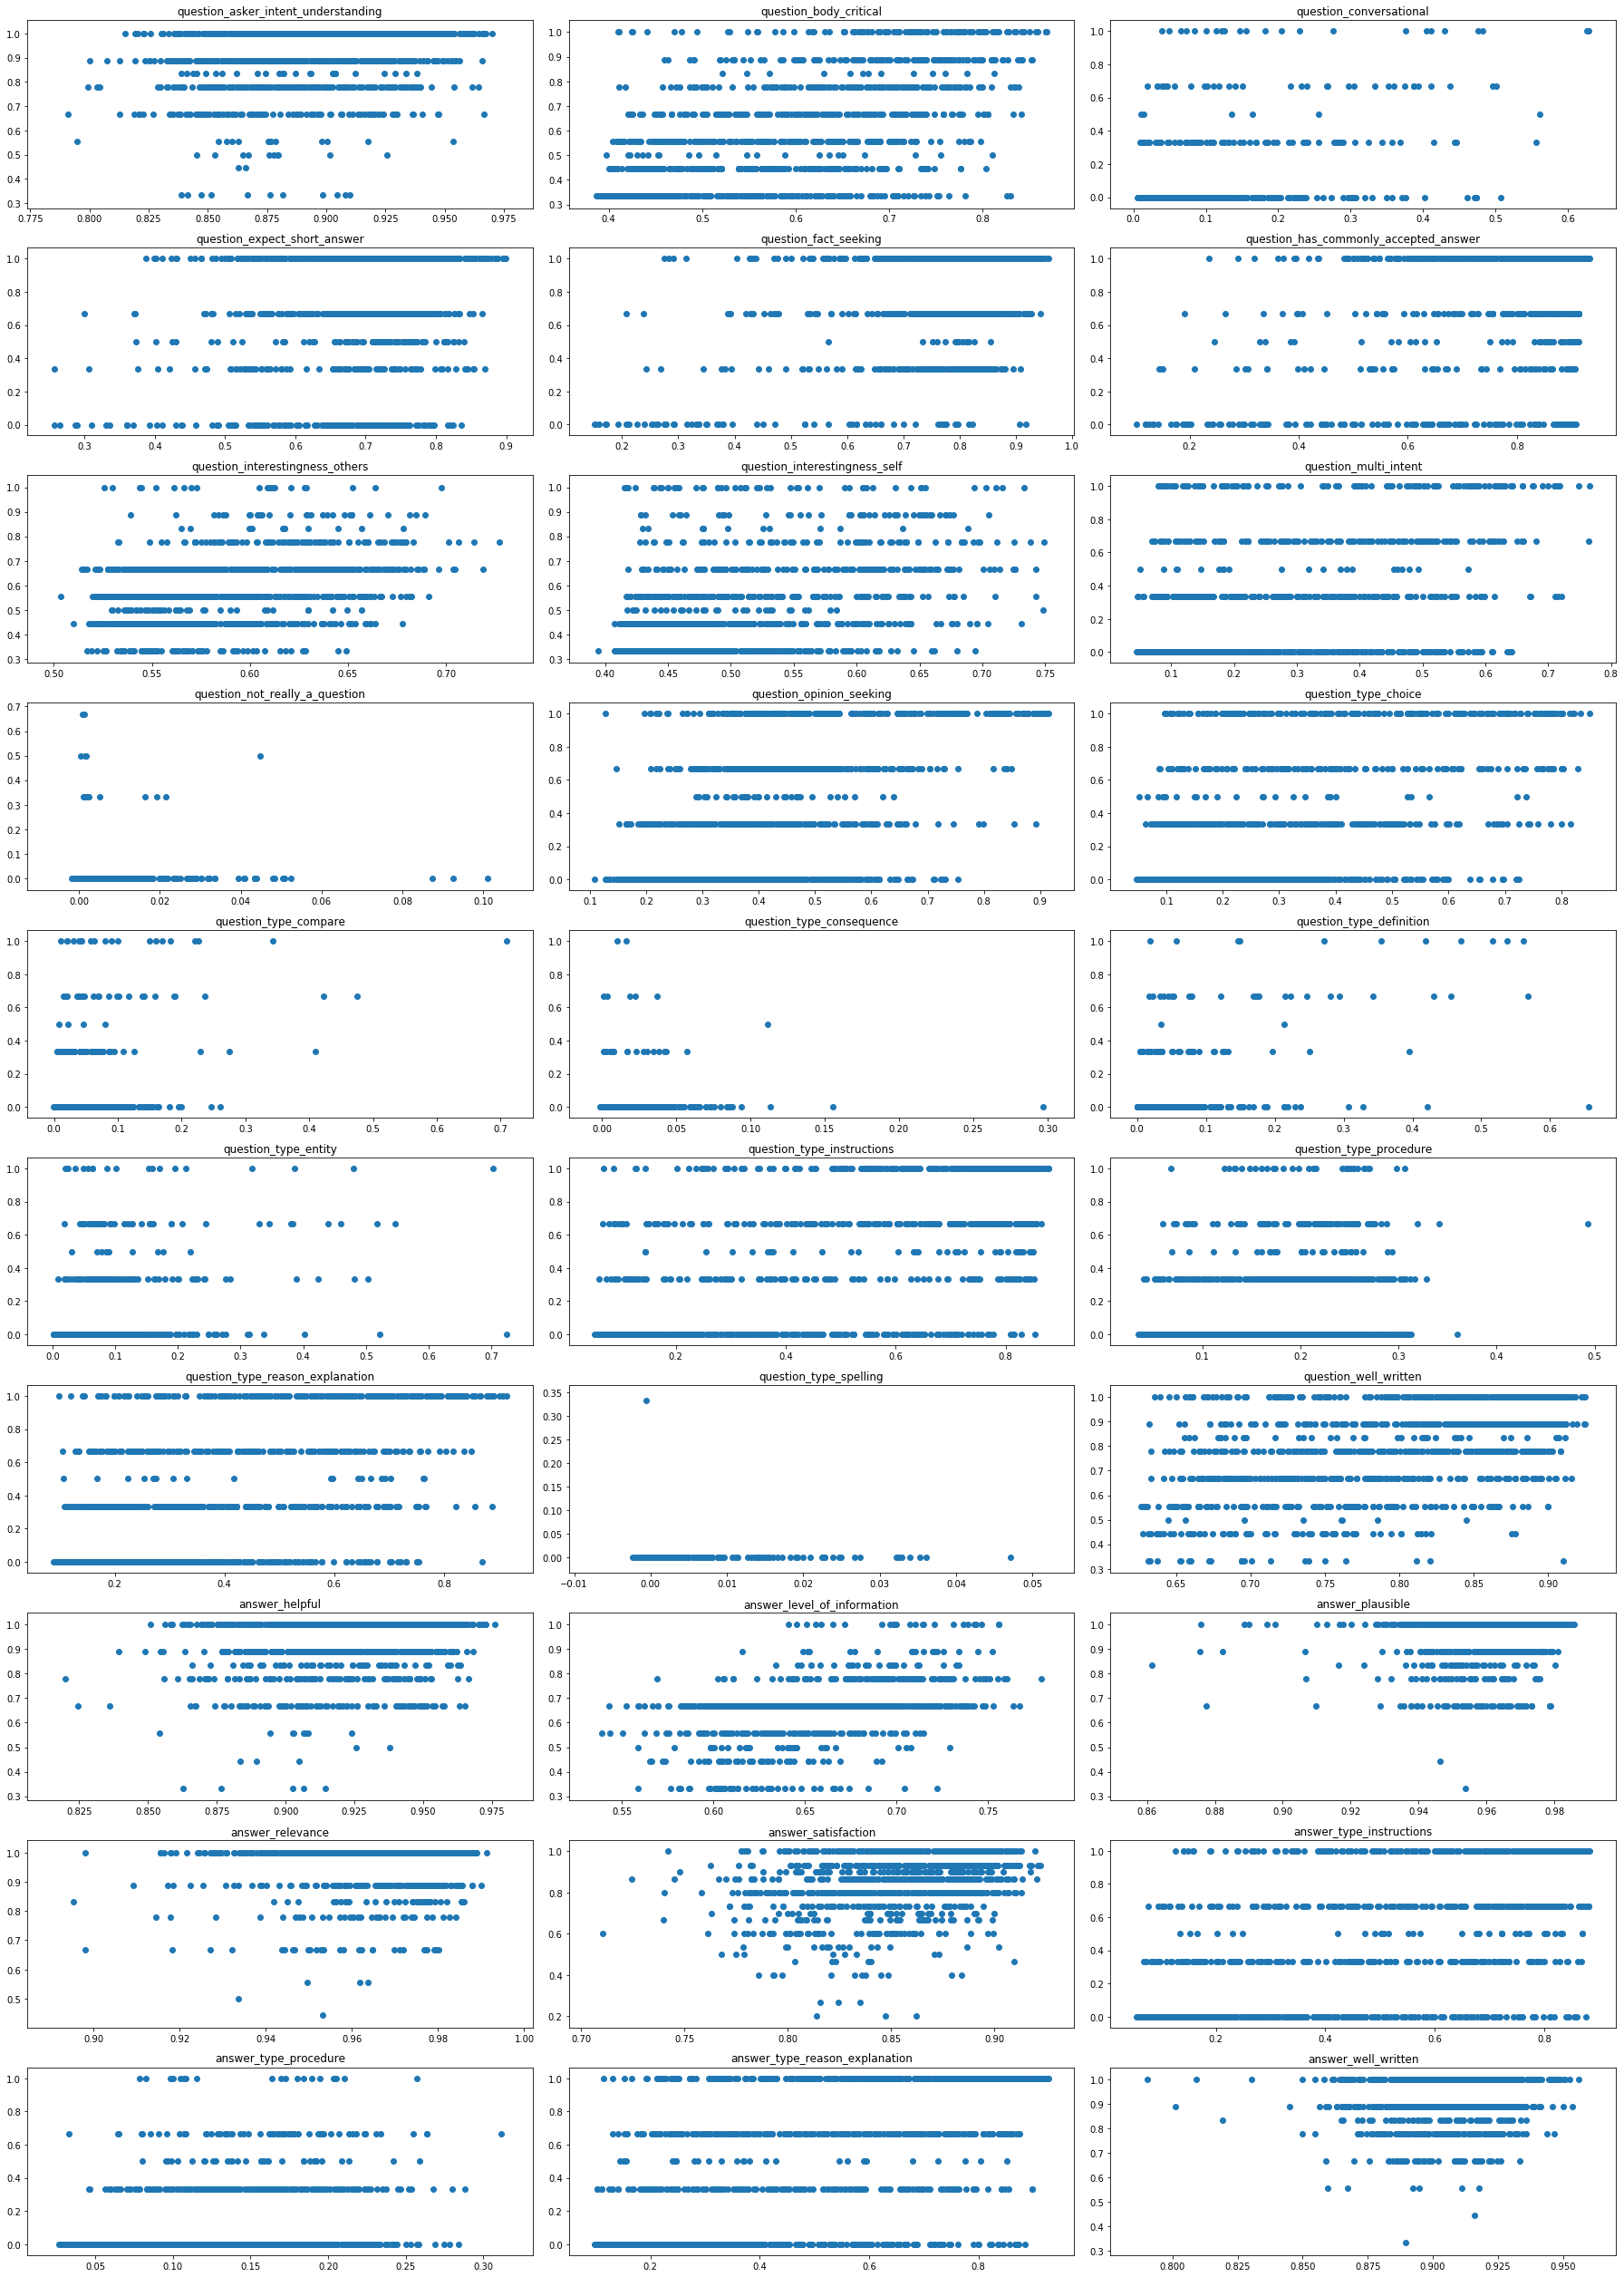

In [29]:
scatterplots(target_names, preds_rf_test, y_test)

# Encoder like

Inspired by encoder architecture, which uses only attention and dense layers, and combines inputs and outputs in attention layers.

In [14]:
# titles - LSTM architecture
input_t = keras.layers.Input(shape=(32,300))
x_t = keras.layers.Attention()([input_t,input_t])
x_t = keras.layers.Masking()(x_t)
x_t = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_t)
x_t = attention_many_to_one()(x_t)
x_t = keras.layers.BatchNormalization()(x_t)
x_t = keras.layers.Dropout(0.3)(x_t)
x_t = keras.layers.Dense(30, activity_regularizer='l2', activation=keras.activations.swish)(x_t)

# questions - encoder like
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.Dropout(0.3)(x_q)
x_q = keras.layers.Dense(256, activity_regularizer='l2', activation=keras.activations.swish)(x_q)
x_q = keras.layers.BatchNormalization()(x_q)

# answers - encoder like
input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.Dropout(0.3)(x_a)
x_a = keras.layers.Dense(256, activity_regularizer='l2', activation=keras.activations.swish)(x_a)
x_a = keras.layers.BatchNormalization()(x_a)

# attention: questions - answers
x_q1 = keras.layers.Attention()([x_q,x_a])
x_q1 = keras.layers.Dropout(0.3)(x_q1)
x_q1 = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_q1)
x_q1 = keras.layers.BatchNormalization()(x_q1)
x_q1 = attention_many_to_one()(x_q1)

# attention: answers - questions
x_a1 = keras.layers.Attention()([x_a,x_q])
x_a1 = keras.layers.Dropout(0.3)(x_a1)
x_a1 = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_a1)
x_a1 = keras.layers.BatchNormalization()(x_a1)
x_a1 = attention_many_to_one()(x_a1)

x = keras.layers.concatenate((x_t, x_q1, x_a1))

x = keras.layers.BatchNormalization(name='last_batch_normalization')(x)

output = keras.layers.Dense(30, activation='sigmoid')(x)

model = keras.Model([input_t, input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [16]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
attention_6 (Attention)         (None, 500, 300)     0           input_5[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
attention_7 (Attention)         (None, 500, 300)     0           input_6[0][0]         

In [17]:
model.fit([X_t_train, X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_t_test, X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 17s 498ms/step - loss: 219.4299 - val_loss: 1.8728
Epoch 2/500
34/34 [==============================] - 14s 415ms/step - loss: 44.3236 - val_loss: 2.6192
Epoch 3/500
34/34 [==============================] - 14s 410ms/step - loss: 29.6068 - val_loss: 3.6120
Epoch 4/500
34/34 [==============================] - 14s 408ms/step - loss: 22.2054 - val_loss: 4.7026
Epoch 5/500
34/34 [==============================] - 14s 408ms/step - loss: 18.2280 - val_loss: 5.8131
Epoch 6/500
34/34 [==============================] - 14s 416ms/step - loss: 15.5583 - val_loss: 6.9628
Epoch 7/500
34/34 [==============================] - 14s 423ms/step - loss: 13.9691 - val_loss: 8.2634
Epoch 8/500
34/34 [==============================] - 14s 417ms/step - loss: 12.8578 - val_loss: 9.7046
Epoch 9/500
34/34 [==============================] - 14s 409ms/step - loss: 12.2774 - val_loss: 11.5816
Epoch 10/500
34/34 [==============================] - 14s 424ms/step - 

In [18]:
model.save_weights('model_weights.h5')

In [15]:
model.load_weights('model_weights.h5')

In [16]:
preds_train = model.predict([X_t_train, X_q_train, X_a_train])
preds_test = model.predict([X_t_test, X_q_test, X_a_test])

In [17]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.11,    mse: 0.143
question_body_critical:                  cor: 0.374,    mse: 0.059
question_conversational:                 cor: -0.011,    mse: 0.208
question_expect_short_answer:            cor: 0.205,    mse: 0.157
question_fact_seeking:                   cor: -0.004,    mse: 0.141
question_has_commonly_accepted_answer:   cor: 0.145,    mse: 0.178
question_interestingness_others:         cor: -0.094,    mse: 0.023
question_interestingness_self:           cor: 0.029,    mse: 0.035
question_multi_intent:                   cor: 0.021,    mse: 0.173
question_not_really_a_question:          cor: 0.054,    mse: 0.207
question_opinion_seeking:                cor: 0.123,    mse: 0.142
question_type_choice:                    cor: 0.219,    mse: 0.184
question_type_compare:                   cor: -0.034,    mse: 0.186
question_type_consequence:               cor: 0.007,    mse: 0.209
question_type_definition:                cor: 0.111,    mse

In [18]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.146,    mse: 0.143
question_body_critical:                  cor: 0.392,    mse: 0.058
question_conversational:                 cor: 0.007,    mse: 0.207
question_expect_short_answer:            cor: 0.174,    mse: 0.152
question_fact_seeking:                   cor: 0.052,    mse: 0.143
question_has_commonly_accepted_answer:   cor: 0.168,    mse: 0.175
question_interestingness_others:         cor: -0.088,    mse: 0.022
question_interestingness_self:           cor: 0.027,    mse: 0.034
question_multi_intent:                   cor: 0.057,    mse: 0.171
question_not_really_a_question:          cor: 0.005,    mse: 0.208
question_opinion_seeking:                cor: 0.114,    mse: 0.136
question_type_choice:                    cor: 0.254,    mse: 0.178
question_type_compare:                   cor: -0.055,    mse: 0.187
question_type_consequence:               cor: 0.027,    mse: 0.209
question_type_definition:                cor: 0.116,    mse:

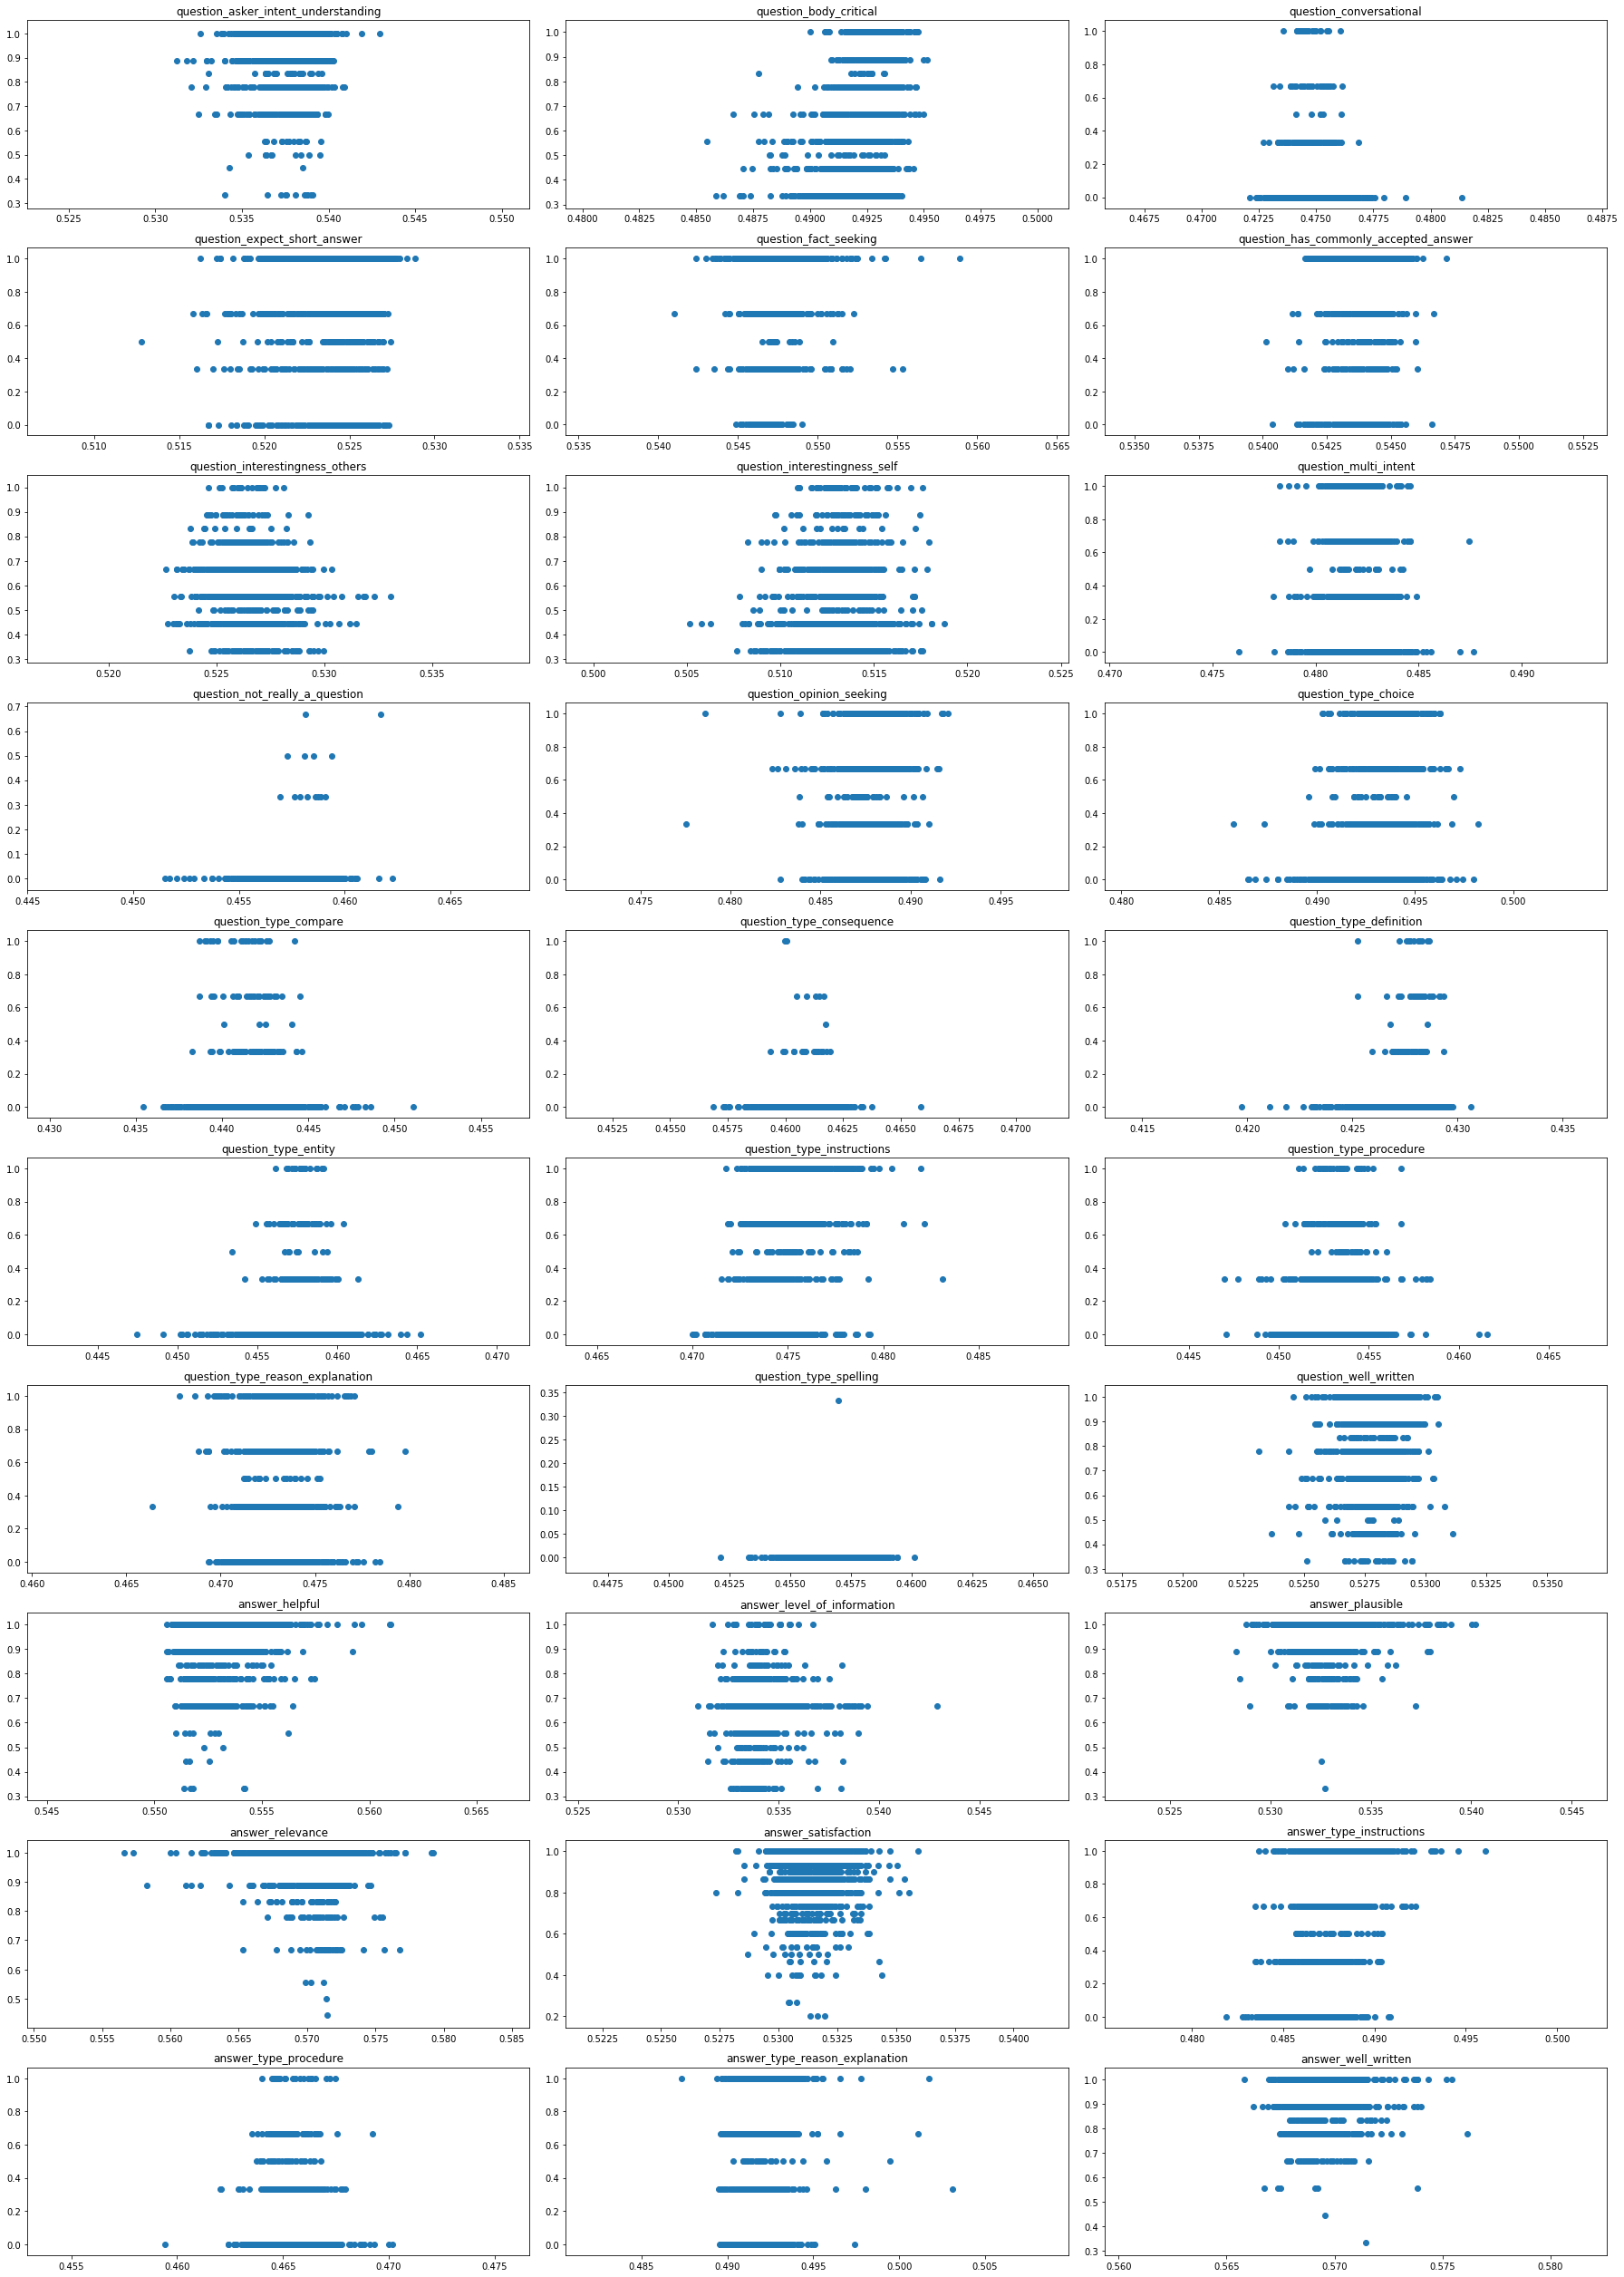

In [19]:
scatterplots(target_names, preds_test, y_test)

# Encoder like with LSTM

In [13]:
# titles - LSTM architecture
input_t = keras.layers.Input(shape=(32,300))
x_t = keras.layers.Attention()([input_t,input_t])
x_t = keras.layers.Masking()(x_t)
x_t = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_t)
x_t = attention_many_to_one()(x_t)
x_t = keras.layers.BatchNormalization()(x_t)
x_t = keras.layers.Dropout(0.3)(x_t)
x_t = keras.layers.Dense(30, activity_regularizer='l2', activation=keras.activations.swish)(x_t)

# questions - encoder like
input_q = keras.layers.Input(shape=(500,300))
x_q = keras.layers.Attention()([input_q,input_q])
x_q = keras.layers.Masking()(x_q)
x_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_q)


# answers - encoder like
input_a = keras.layers.Input(shape=(500,300))
x_a = keras.layers.Attention()([input_a,input_a])
x_a = keras.layers.Masking()(x_a)
x_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_a)

# attention: questions - answers
x = keras.layers.Attention()([x_q,x_a])
x = keras.layers.Masking()(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x)
x = attention_many_to_one()(x)


x = keras.layers.concatenate((x_t, x))

output = keras.layers.Dense(30, activation='sigmoid')(x)

model = keras.Model([input_t, input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [32]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 300)]    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
attention_5 (Attention)         (None, 32, 300)      0           input_4[0][0]                    
                                                                 input_4[0][0]         

In [33]:
model.fit([X_t_train, X_q_train, X_a_train], y_train, batch_size=145, epochs=500, callbacks=[earlystopping], validation_data=([X_t_test, X_q_test, X_a_test], y_test))

Epoch 1/500
34/34 [==============================] - 38s 1s/step - loss: 0.6097 - val_loss: 0.2580
Epoch 2/500
34/34 [==============================] - 30s 892ms/step - loss: 0.2855 - val_loss: 0.1830
Epoch 3/500
34/34 [==============================] - 32s 928ms/step - loss: 0.2087 - val_loss: 0.1391
Epoch 4/500
34/34 [==============================] - 31s 918ms/step - loss: 0.1667 - val_loss: 0.1191
Epoch 5/500
34/34 [==============================] - 32s 932ms/step - loss: 0.1433 - val_loss: 0.1077
Epoch 6/500
34/34 [==============================] - 31s 916ms/step - loss: 0.1281 - val_loss: 0.1001
Epoch 7/500
34/34 [==============================] - 31s 907ms/step - loss: 0.1171 - val_loss: 0.0947
Epoch 8/500
34/34 [==============================] - 31s 913ms/step - loss: 0.1087 - val_loss: 0.0905
Epoch 9/500
34/34 [==============================] - 31s 899ms/step - loss: 0.1022 - val_loss: 0.0871
Epoch 10/500
34/34 [==============================] - 31s 906ms/step - loss: 0.0969 -

In [34]:
model.save_weights('model_weights.h5')

In [14]:
model.load_weights('model_weights.h5')

In [15]:
preds_train = model.predict([X_t_train, X_q_train, X_a_train])
preds_test = model.predict([X_t_test, X_q_test, X_a_test])

In [16]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.236,    mse: 0.017
question_body_critical:                  cor: 0.497,    mse: 0.038
question_conversational:                 cor: 0.341,    mse: 0.034
question_expect_short_answer:            cor: 0.107,    mse: 0.124
question_fact_seeking:                   cor: 0.17,    mse: 0.083
question_has_commonly_accepted_answer:   cor: 0.306,    mse: 0.1
question_interestingness_others:         cor: 0.321,    mse: 0.017
question_interestingness_self:           cor: 0.383,    mse: 0.03
question_multi_intent:                   cor: 0.209,    mse: 0.108
question_not_really_a_question:          cor: 0.022,    mse: 0.009
question_opinion_seeking:                cor: 0.3,    mse: 0.125
question_type_choice:                    cor: 0.343,    mse: 0.121
question_type_compare:                   cor: 0.208,    mse: 0.031
question_type_consequence:               cor: 0.048,    mse: 0.011
question_type_definition:                cor: 0.123,    mse: 0.024
q

In [17]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.251,    mse: 0.018
question_body_critical:                  cor: 0.588,    mse: 0.034
question_conversational:                 cor: 0.363,    mse: 0.031
question_expect_short_answer:            cor: 0.173,    mse: 0.12
question_fact_seeking:                   cor: 0.261,    mse: 0.081
question_has_commonly_accepted_answer:   cor: 0.371,    mse: 0.093
question_interestingness_others:         cor: 0.321,    mse: 0.016
question_interestingness_self:           cor: 0.437,    mse: 0.028
question_multi_intent:                   cor: 0.27,    mse: 0.105
question_not_really_a_question:          cor: 0.042,    mse: 0.009
question_opinion_seeking:                cor: 0.364,    mse: 0.115
question_type_choice:                    cor: 0.434,    mse: 0.111
question_type_compare:                   cor: 0.177,    mse: 0.024
question_type_consequence:               cor: 0.103,    mse: 0.011
question_type_definition:                cor: 0.147,    mse: 0.0

/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/anaconda/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/anaconda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


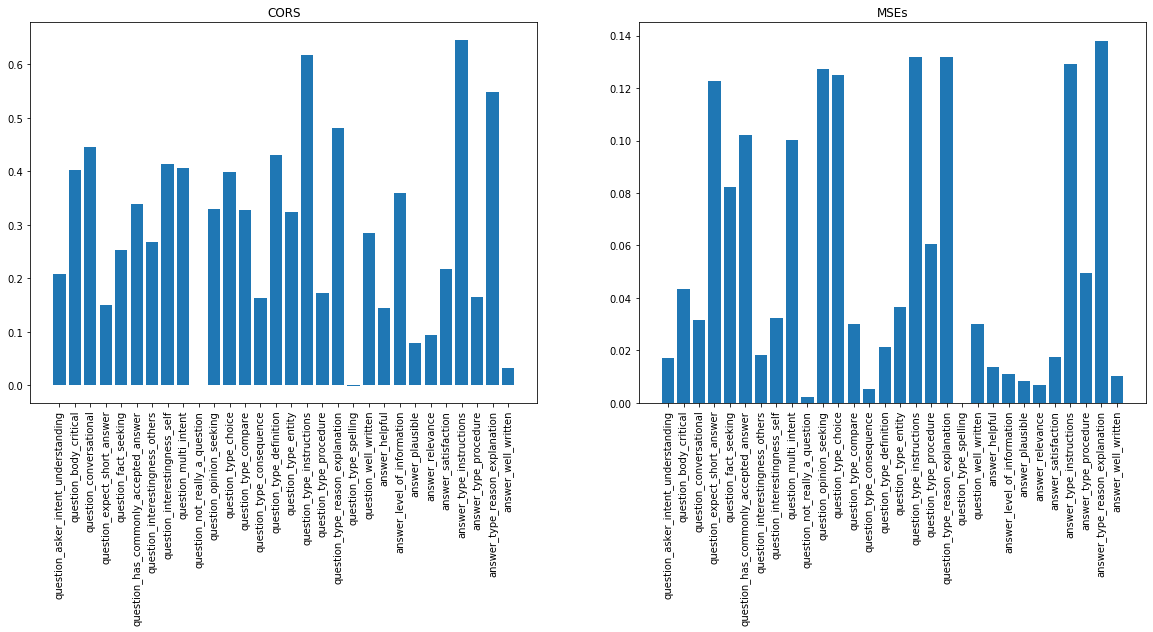

In [20]:
plot_cors_mse(target_names, preds_test, y_test)

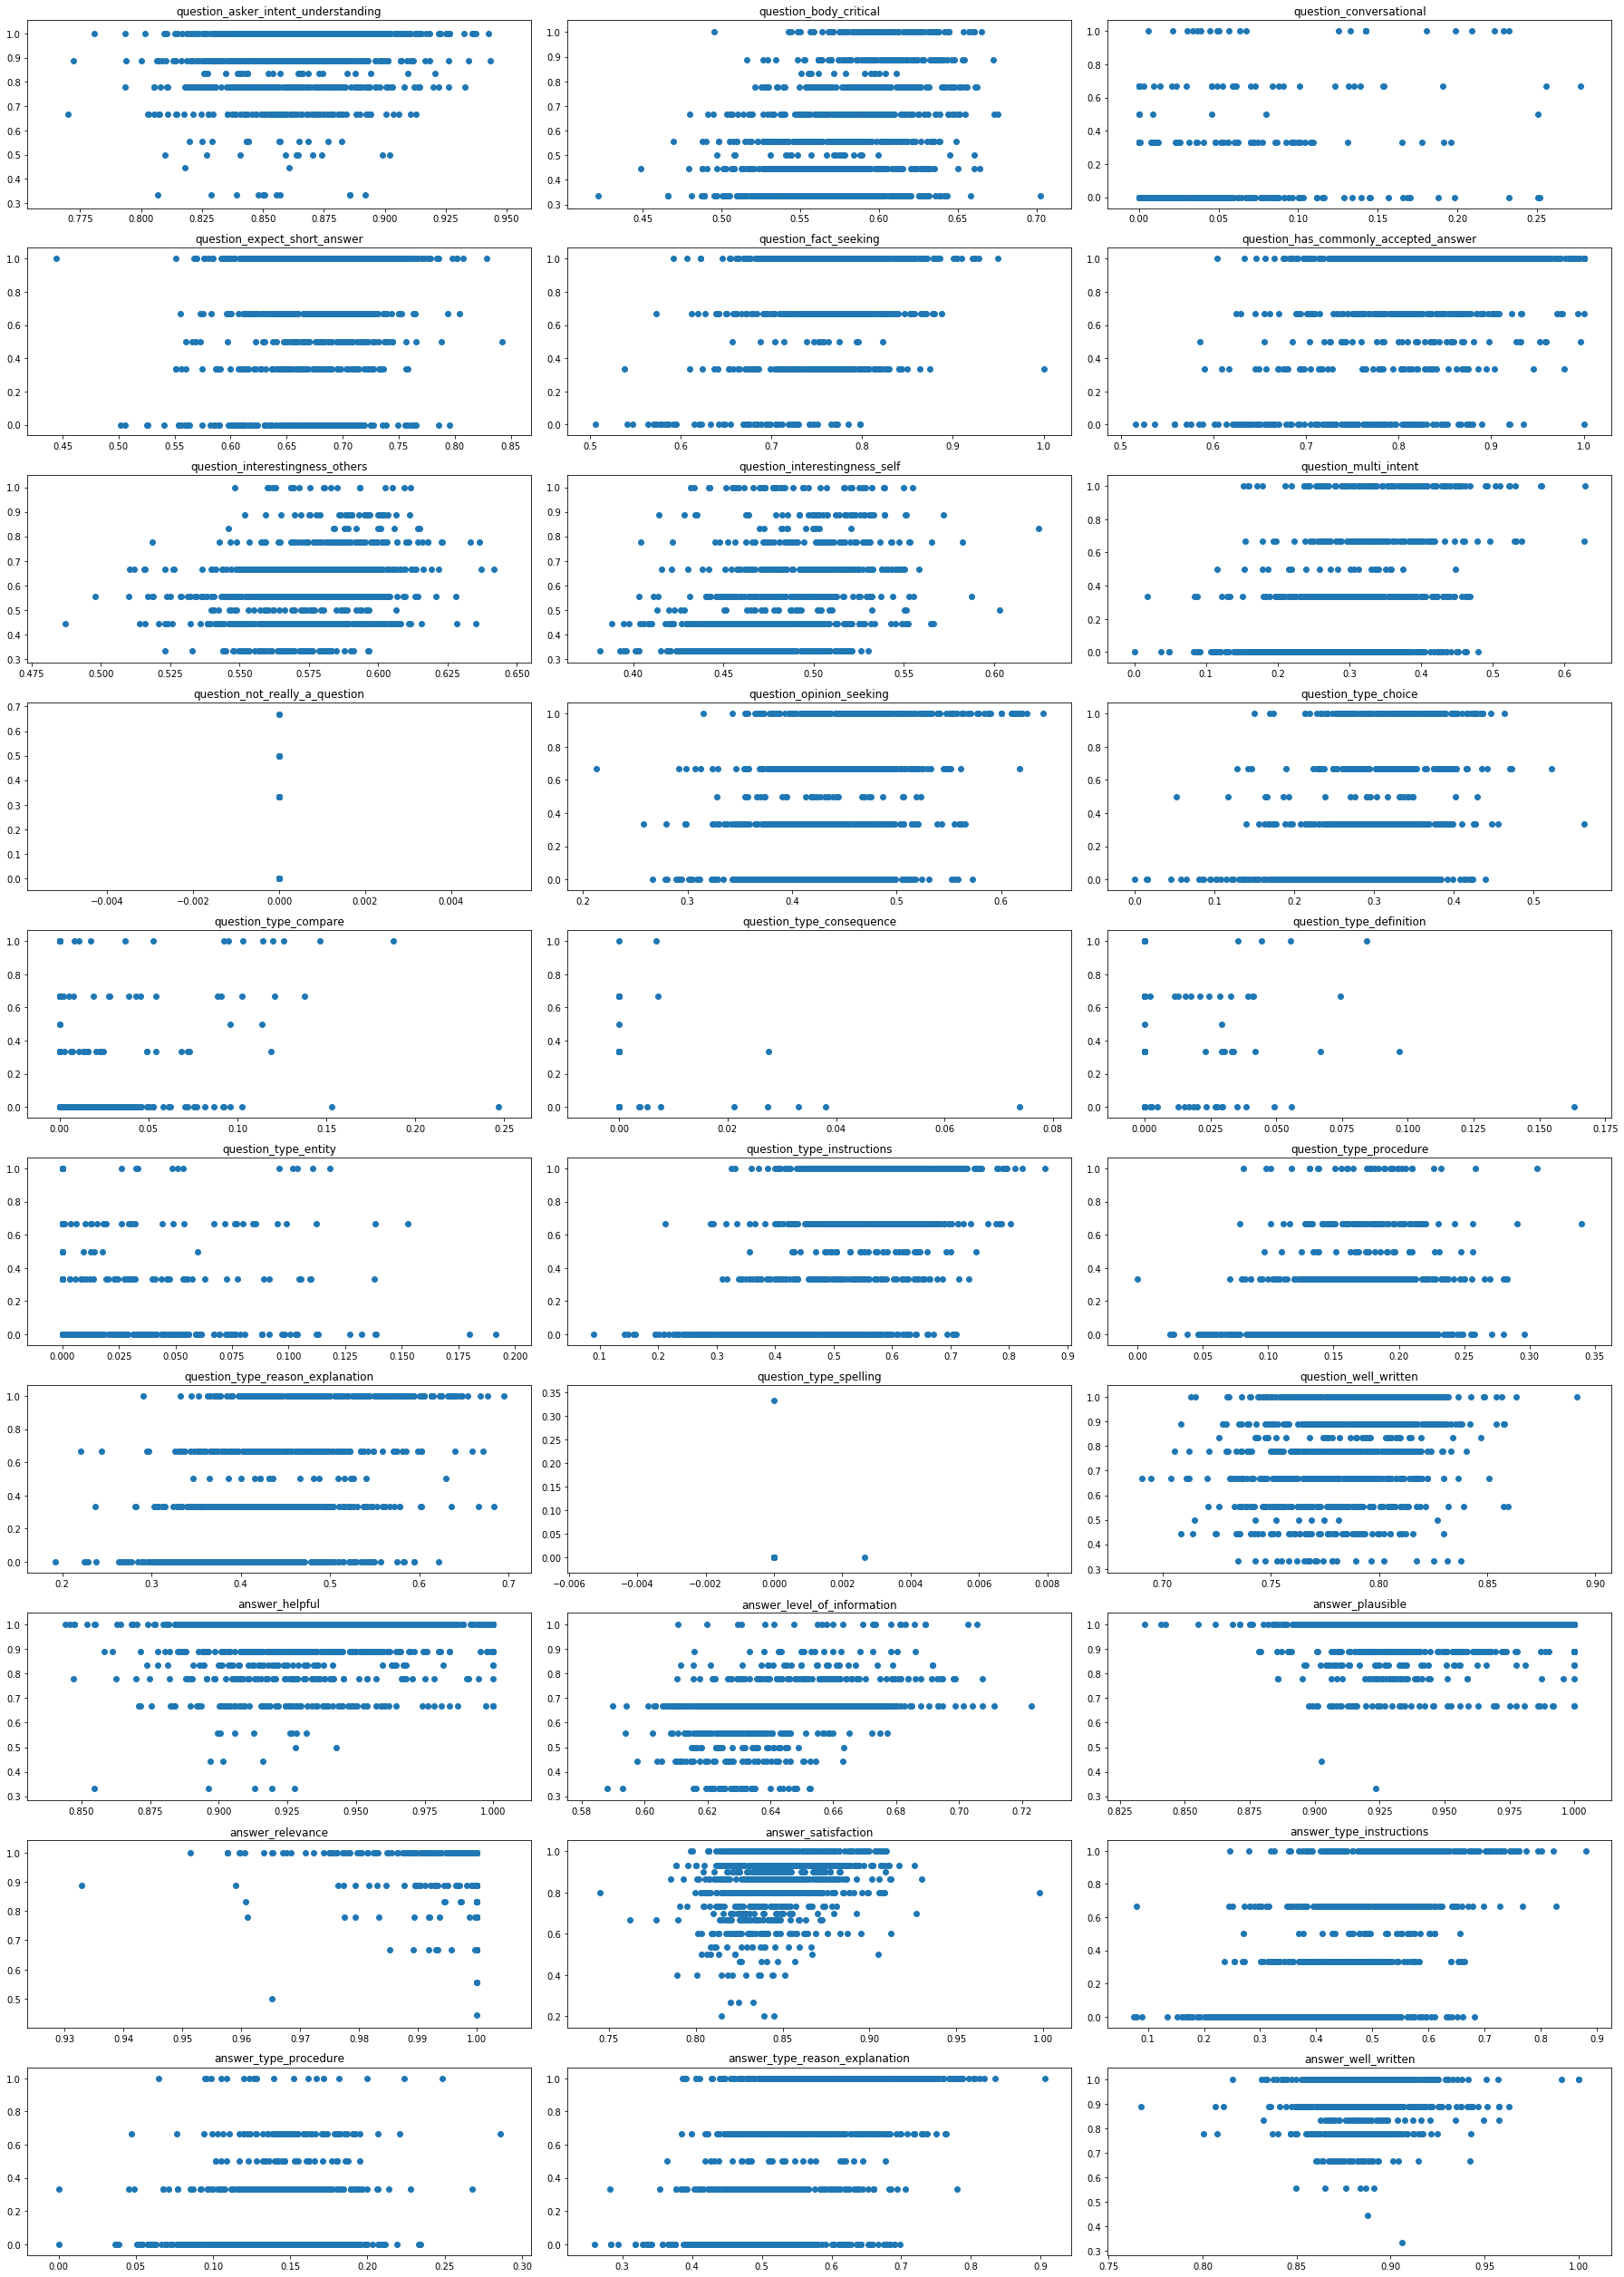

In [21]:
scatterplots(target_names, preds_test, y_test)